### Introduction

#### Importing necessary libraries

In [1]:
#Importing necessary libraries
%matplotlib inline
import matplotlib as mpl
#from matplotlib import colors
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
import pandas as pd
import numpy as np
import glob
import os
import time
import sys
from itertools import cycle
from scipy import interp

#Various sklearn utilities and metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, GridSearchCV, ShuffleSplit
from sklearn.metrics import classification_report, auc, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures, LabelBinarizer, label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, VotingClassifier)

#### Getting local directory and loading data

In [2]:
#Get current working directory
cwd = os.getcwd()
#Read energy simulation results
Results = pd.read_csv(cwd + "\\Energy_Results.csv")

In [3]:
Results.head(5)

ClimateZone Orientation  WWR GlazingType  SHGC  OverhangLength  HVAC  \
0            1        Core   20          DP   0.2             0.5    11   
1            1        Core   20          DP   0.2             0.5    11   
2            1        Core   20          DP   0.2             0.5    16   
3            1        Core   20          DP   0.2             0.5    16   
4            1        Core   20          DP   0.2             0.5    16   

   HeatRecovery     Cooling     Heating      ...        AverageMRT     MinMRT  \
0             1  311.812896   20.883695      ...         24.005318  22.196365   
1             2  300.340893    0.626567      ...         24.005314  22.196309   
2             0  721.700049  301.654383      ...         24.274933  23.090055   
3             1  710.907858  138.222897      ...         24.274645  23.088821   
4             2  694.776674   79.718053      ...         24.274726  23.088366   

      MaxMRT  AverageRH      MinRH      MaxRH  PeakCoolingLoad  \
0  24.608786  52.766281  11.492039  81.201879         549.9763   
1  24.608843  52.423143  12.634105  81.096689         549.9763   
2  25.423161  54.297460  12.561028  78.194042         549.9763   
3  25.422741  54.407838  12.591474  78.193935         549.9763   
4  25.423729  54.590228  13.629492  78.255193         549.9763   

   PeakHeatingLoad  CoolingSizing  HeatingSizing  
0              0.0      632.47274            0.0  
1              0.0      632.47274            0.0  
2              0.0      632.47274            0.0  
3              0.0      632.47274            0.0  
4              0.0      632.47274            0.0  

[5 rows x 29 columns]

### Data Preprocessing

#### Check unique values of categorical variables

In [4]:
#Check unique values of categorical variables
print(Results['Orientation'].unique())
print(Results['GlazingType'].unique())
print(Results['HVAC'].unique())

['Core' 'East' 'North' 'South' 'West']
['DP' 'TP']
[11 16  7]


#### Turn categorical variables to numeric labels

In [5]:
#Label encoding of categorical features

ORLabel = LabelEncoder()
orientation_labels = ORLabel.fit_transform(Results['Orientation'])
orientation_mapping = {index: label for index, label in enumerate(ORLabel.classes_)}
print("Orientation label mapping:", orientation_mapping)
Results['Orientation'] = orientation_labels

glzLabel = LabelEncoder()
glazing_labels = glzLabel.fit_transform(Results['GlazingType'])
glz_mapping = {index: label for index, label in enumerate(glzLabel.classes_)}
print("Glazing Type label mapping:", glz_mapping)
Results['GlazingType'] = glazing_labels

hvacLabel = LabelEncoder()
hvac_labels = hvacLabel.fit_transform(Results['HVAC'])
hvac_mapping = {index: label for index, label in enumerate(hvacLabel.classes_)}
print("HVAC Type label mapping:", hvac_mapping)
Results['HVAC'] = hvac_labels

Orientation label mapping: {0: 'Core', 1: 'East', 2: 'North', 3: 'South', 4: 'West'}
Glazing Type label mapping: {0: 'DP', 1: 'TP'}
HVAC Type label mapping: {0: 7, 1: 11, 2: 16}


In [6]:
Results.head()

ClimateZone  Orientation  WWR  GlazingType  SHGC  OverhangLength  HVAC  \
0            1            0   20            0   0.2             0.5     1   
1            1            0   20            0   0.2             0.5     1   
2            1            0   20            0   0.2             0.5     2   
3            1            0   20            0   0.2             0.5     2   
4            1            0   20            0   0.2             0.5     2   

   HeatRecovery     Cooling     Heating      ...        AverageMRT     MinMRT  \
0             1  311.812896   20.883695      ...         24.005318  22.196365   
1             2  300.340893    0.626567      ...         24.005314  22.196309   
2             0  721.700049  301.654383      ...         24.274933  23.090055   
3             1  710.907858  138.222897      ...         24.274645  23.088821   
4             2  694.776674   79.718053      ...         24.274726  23.088366   

      MaxMRT  AverageRH      MinRH      MaxRH  PeakCoolingLoad  \
0  24.608786  52.766281  11.492039  81.201879         549.9763   
1  24.608843  52.423143  12.634105  81.096689         549.9763   
2  25.423161  54.297460  12.561028  78.194042         549.9763   
3  25.422741  54.407838  12.591474  78.193935         549.9763   
4  25.423729  54.590228  13.629492  78.255193         549.9763   

   PeakHeatingLoad  CoolingSizing  HeatingSizing  
0              0.0      632.47274            0.0  
1              0.0      632.47274            0.0  
2              0.0      632.47274            0.0  
3              0.0      632.47274            0.0  
4              0.0      632.47274            0.0  

[5 rows x 29 columns]

In [7]:
Results.iloc[:,:13].head()

ClimateZone  Orientation  WWR  GlazingType  SHGC  OverhangLength  HVAC  \
0            1            0   20            0   0.2             0.5     1   
1            1            0   20            0   0.2             0.5     1   
2            1            0   20            0   0.2             0.5     2   
3            1            0   20            0   0.2             0.5     2   
4            1            0   20            0   0.2             0.5     2   

   HeatRecovery     Cooling     Heating    Lighting        Fans      Pumps  
0             1  311.812896   20.883695  612.913717   58.941109  92.912378  
1             2  300.340893    0.626567  612.913717   58.863011  92.166292  
2             0  721.700049  301.654383  612.913717  267.528228  46.442213  
3             1  710.907858  138.222897  612.913717  267.528228  34.807325  
4             2  694.776674   79.718053  612.913717  267.528228  28.000885

#### Encode all categorical variables using Category Encoders

In [9]:
#Apply different feature encoding, using category_encoders library
import category_encoders as ce
X = Results.iloc[:, :8] #slice out the features we want to use

#Calculate total energy consumption
y = (Results.iloc[:, 8] + Results.iloc[:, 9] + Results.iloc[:, 10] + Results.iloc[:, 11] + 
     Results.iloc[:, 12])

#Binary encoding
binary = ce.BinaryEncoder(verbose=1, drop_invariant=True, 
                          cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_bin = binary.transform(X)

#Backward Difference encoding
backward = ce.BackwardDifferenceEncoder(verbose=1, drop_invariant=True, 
                                        cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_bd = backward.transform(X)

#Hashing encoding
hashing = ce.HashingEncoder(verbose=1, drop_invariant=True, 
                            cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_hash = hashing.transform(X)

#Helmert encoding
helmert = ce.HelmertEncoder(verbose=1, drop_invariant=True, 
                            cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_helmert = helmert.transform(X)

#One-hot-encoding
oneHot = ce.OneHotEncoder(verbose=1, drop_invariant=True, 
                          cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_onh = oneHot.transform(X)

#Ordinal encoding
ordinal = ce.OrdinalEncoder(verbose=1, drop_invariant=True, 
                            cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_ord = ordinal.transform(X)

#Leave one out encoding
lou = ce.LeaveOneOutEncoder(verbose=1, drop_invariant=True, 
                            cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_lou = lou.transform(X)

#Polynomial encoding
polynomial = ce.PolynomialEncoder(verbose=1, drop_invariant=True, 
                                  cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_poly = polynomial.transform(X)

#Sum encoding
sumenc = ce.SumEncoder(verbose=1, drop_invariant=True, 
                       cols=['ClimateZone', 'Orientation', 'GlazingType', 'HVAC', 'HeatRecovery']).fit(X, y)
Results_sum = sumenc.transform(X)

#### Save encoded data into a python dictionary for later use

In [10]:
#Save all encodings in a python dictionary
processed_data = {'binary': Results_bin, 'backward': Results_bd, 'hashing': Results_hash, 'helmert': Results_helmert, 
                  'oneHot': Results_onh, 'ordinal': Results_ord, 'lou': Results_lou, 'polynomial': Results_poly,
                  'sumenc': Results_sum}

#Save encodings to disk for later use, uncomment this if you are running for the first time
#np.save('Encoded_data.npy', processed_data)

#### Normalize target variable and generate 10 classes

In [11]:
#Normalize consumption to room floor area
y_norm = y / 16

y_classes = np.empty((len(y_norm),1))

for i in range(0, len(y_norm)):
    if(y_norm[i] < np.percentile(y_norm, q=10)):
        y_classes[i] = 0
    elif((y_norm[i] > np.percentile(y_norm, q=10) and (y_norm[i] < np.percentile(y_norm, q=20)))):
        y_classes[i] = 1
    elif((y_norm[i] > np.percentile(y_norm, q=20) and (y_norm[i] < np.percentile(y_norm, q=30)))):
        y_classes[i] = 2
    elif((y_norm[i] > np.percentile(y_norm, q=30) and (y_norm[i] < np.percentile(y_norm, q=40)))):
        y_classes[i] = 3
    elif((y_norm[i] > np.percentile(y_norm, q=40) and (y_norm[i] < np.percentile(y_norm, q=50)))):
        y_classes[i] = 4
    elif((y_norm[i] > np.percentile(y_norm, q=50) and (y_norm[i] < np.percentile(y_norm, q=60)))):
        y_classes[i] = 5
    elif((y_norm[i] > np.percentile(y_norm, q=60) and (y_norm[i] < np.percentile(y_norm, q=70)))):
        y_classes[i] = 6
    elif((y_norm[i] > np.percentile(y_norm, q=70) and (y_norm[i] < np.percentile(y_norm, q=80)))):
        y_classes[i] = 7
    elif((y_norm[i] > np.percentile(y_norm, q=80) and (y_norm[i] < np.percentile(y_norm, q=90)))):
        y_classes[i] = 8
    else:
        y_classes[i] = 9

#### Save classes array to the disk

In [12]:
#Save the classes information to disk for later use, uncomment this if you are running for the first time
#np.save('10Classes.npy', y_classes)

#### Load classes array from the disk

In [14]:
y_classes = np.load('10Classes.npy')

#### One hot encode classes

In [20]:
#Change target variable to appropriate format
labelBin = LabelBinarizer()
y_classes_labeled = labelBin.fit_transform(y_classes)
y_classes_labeled = y_classes_labeled.astype('int32')

In [21]:
print(y_classes_labeled)

[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]]


#### Save encoded classes to disk

In [37]:
np.save(r'D:\Projects\Research\SimAud_ParametricAI\MLPart\Data\Target_classes_processed', y_classes_labeled)

#### Helper function to plot learning curves

In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=8, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(15,10))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring='accuracy', train_sizes=train_sizes, shuffle=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

### Train RandomForest Classifier on different categorical encodings

#### Conduct a GridSearch to identify optimal hyperparameters

In [24]:
#Run initial GridSearchCV study to identify good hyperparameter values 
# (only run this once, load results below if you have before)
estimator = RandomForestClassifier(n_estimators=100, random_state=1337)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

forestGrid = GridSearchCV(estimator, param_grid=param_grid, cv=5, scoring='accuracy')

forestGrid.fit(Results_bin, y_classes_labeled)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1337, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 5, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

#### Best estimator and hyperparameters

In [28]:
#Show the best estimator and its parameters
forestGrid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1337, verbose=0,
            warm_start=False)

#### Load grid search from disk

In [4]:
#Load these files if you're starting over, if not skip this cell
forestGrid = joblib.load(cwd + "\\RF_Grid_bin.pkl")

#### Train Classifier on different encodings

##### Binary encoding

               precision    recall  f1-score   support

       <60kWh       0.96      0.95      0.96      1327
  60kWh-71kWh       0.93      0.84      0.89      1354
  71kWh-81kWh       0.92      0.79      0.85      1343
  81kWh-93kWh       0.91      0.70      0.79      1339
 93kWh-103kWh       0.91      0.62      0.74      1359
103kWh-116kWh       0.86      0.56      0.68      1353
116kWh-128kWh       0.87      0.54      0.67      1328
128kWh-146kWh       0.84      0.55      0.66      1360
146kWh-171kWh       0.86      0.63      0.73      1359
      >171kWh       0.97      0.84      0.90      1473

  avg / total       0.90      0.70      0.79     13595

[[1297   30    0    0    0    0    0    0    0    0]
 [ 186 1141   26    1    0    0    0    0    0    0]
 [ 207   49 1064   22    0    0    0    0    0    1]
 [ 317    1   59  936   26    0    0    0    0    0]
 [ 401    0    1   68  838   51    0    0    0    0]
 [ 509    0    1    1   50  762   29    0    0    1]
 [ 497    0    0   

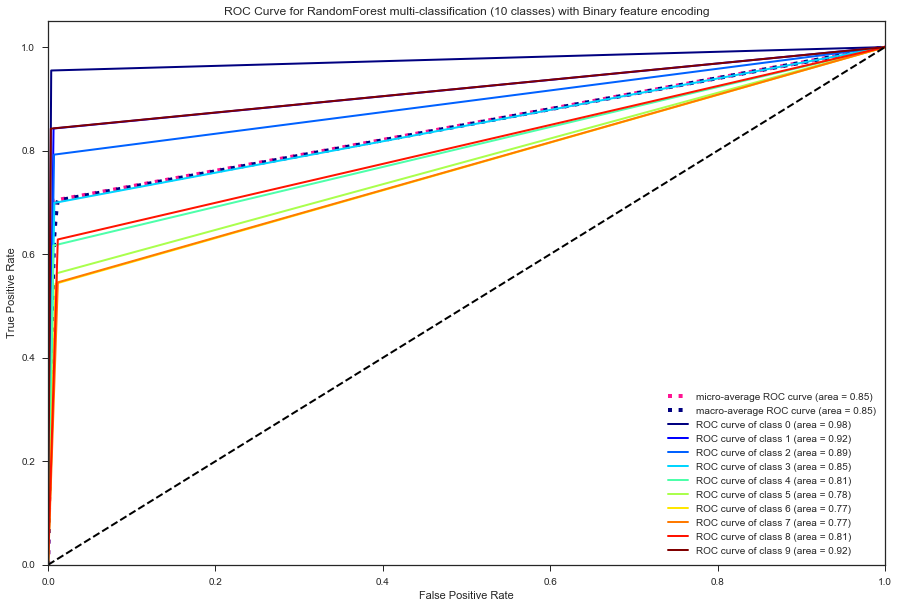

In [31]:
rndForest_bin = forestGrid.best_estimator_
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_bin, y_classes_labeled, test_size=0.3, stratify=y_classes_labeled, 
                                                    random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
rndForest_bin.fit(X_train,y_train)
y_pred_bin = rndForest_bin.predict(X_test).astype(np.float)
y_bin_proba = rndForest_bin.predict_proba(X_test)

#Show classification report
print(classification_report(y_test, y_pred_bin, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_bin.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Binary feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Binary_10Classes.png', dpi=200)
plt.show()

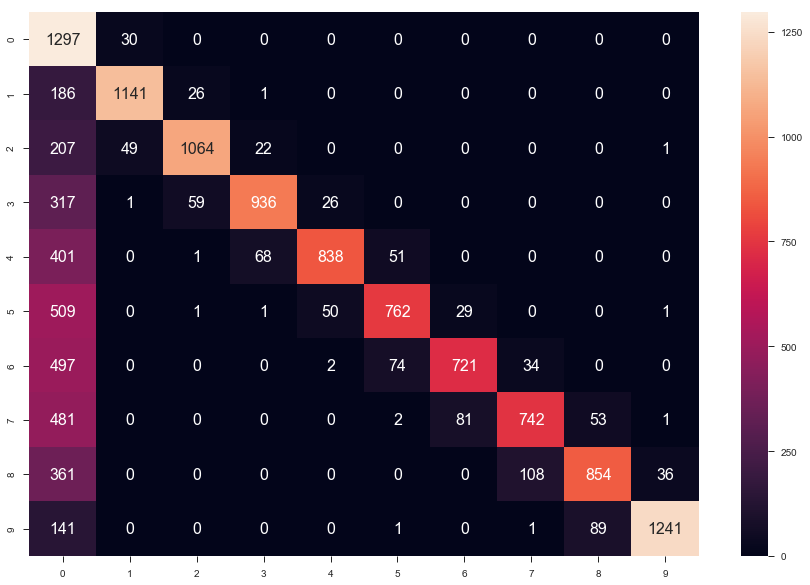

In [40]:
#Create our confusion matrix [object]
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_bin, axis=1))

#Plot confusion matrix to visualise performance
plt.figure(figsize=(15,10))
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

##### Backward differencing encoding

               precision    recall  f1-score   support

       <60kWh       0.10      0.10      0.10      1277
  60kWh-71kWh       0.10      0.09      0.10      1307
  71kWh-81kWh       0.10      0.09      0.09      1344
  81kWh-93kWh       0.10      0.08      0.08      1307
 93kWh-103kWh       0.10      0.07      0.08      1342
103kWh-116kWh       0.10      0.07      0.08      1332
116kWh-128kWh       0.10      0.06      0.08      1380
128kWh-146kWh       0.10      0.07      0.08      1372
146kWh-171kWh       0.10      0.07      0.09      1440
      >171kWh       0.10      0.09      0.10      1494

  avg / total       0.10      0.08      0.09     13595

[[1250   27    0    0    0    0    0    0    0    0]
 [ 168 1103   35    1    0    0    0    0    0    0]
 [ 208   79 1023   34    0    0    0    0    0    0]
 [ 275    4   59  937   32    0    0    0    0    0]
 [ 374    0    1   68  867   31    0    0    0    1]
 [ 496    0    1    2   74  722   36    0    0    1]
 [ 484    0    0   

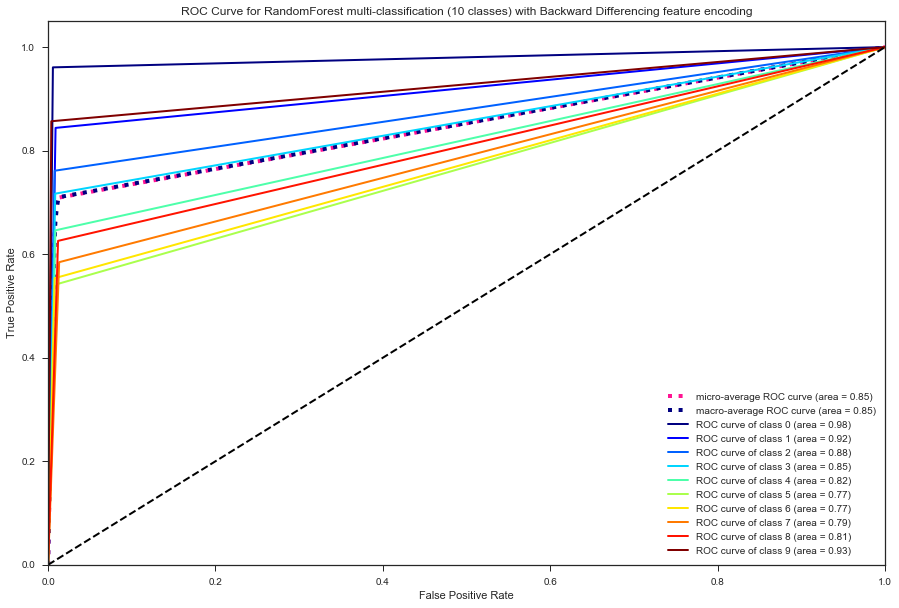

In [41]:
rndForest_bd = forestGrid.best_estimator_
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_bd, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
rndForest_bd.fit(X_train,y_train)
y_pred_bd = rndForest_bd.predict(X_test).astype(np.float)
y_bd_proba = rndForest_bd.predict_proba(X_test)

#Show classification report
print(classification_report(y_test, y_pred_bin, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_bd.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_bd[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_bd.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Backward Differencing feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_BackDiff_10Classes.png', dpi=200)
plt.show()

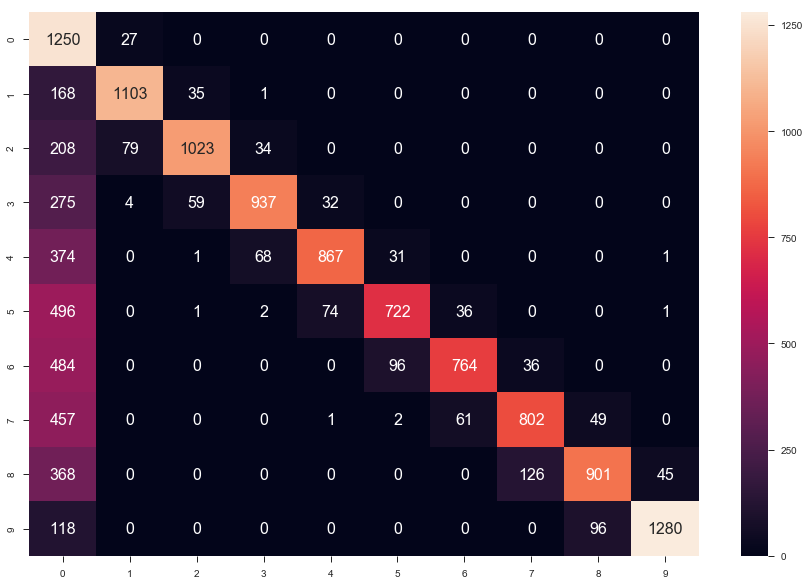

In [42]:
#Create our confusion matrix [object]
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_bd, axis=1))

#Plot confusion matrix to visualise performance
plt.figure(figsize=(15,10))
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

##### Helmert encoding

               precision    recall  f1-score   support

       <60kWh       0.95      0.97      0.96      1277
  60kWh-71kWh       0.90      0.86      0.88      1307
  71kWh-81kWh       0.90      0.80      0.85      1344
  81kWh-93kWh       0.88      0.76      0.82      1307
 93kWh-103kWh       0.88      0.70      0.78      1342
103kWh-116kWh       0.82      0.60      0.70      1332
116kWh-128kWh       0.84      0.61      0.71      1380
128kWh-146kWh       0.78      0.63      0.70      1372
146kWh-171kWh       0.84      0.66      0.74      1440
      >171kWh       0.96      0.87      0.91      1494

  avg / total       0.88      0.75      0.80     13595

[[1244   33    0    0    0    0    0    0    0    0]
 [ 129 1127   49    1    0    0    0    0    0    1]
 [ 140   81 1081   40    0    0    0    0    0    2]
 [ 198    5   65  996   43    0    0    0    0    0]
 [ 259    0    1   90  940   51    0    0    0    1]
 [ 369    0    1    2   89  804   65    0    0    2]
 [ 342    0    0   

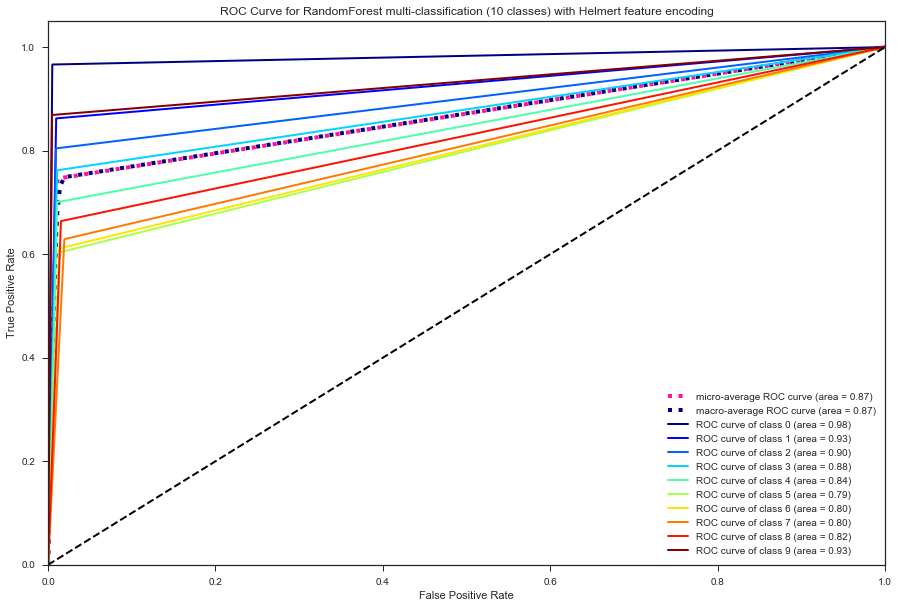

In [44]:
rndForest_helmert = forestGrid.best_estimator_
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_helmert, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
rndForest_helmert.fit(X_train,y_train)
y_pred_helmert = rndForest_helmert.predict(X_test).astype(np.float)
y_helmert_proba = rndForest_helmert.predict_proba(X_test)

#Show classification report
print(classification_report(y_test, y_pred_helmert, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_helmert.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_helmert[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_helmert.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Helmert feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Helmert_10Classes.png', dpi=200)
plt.show()

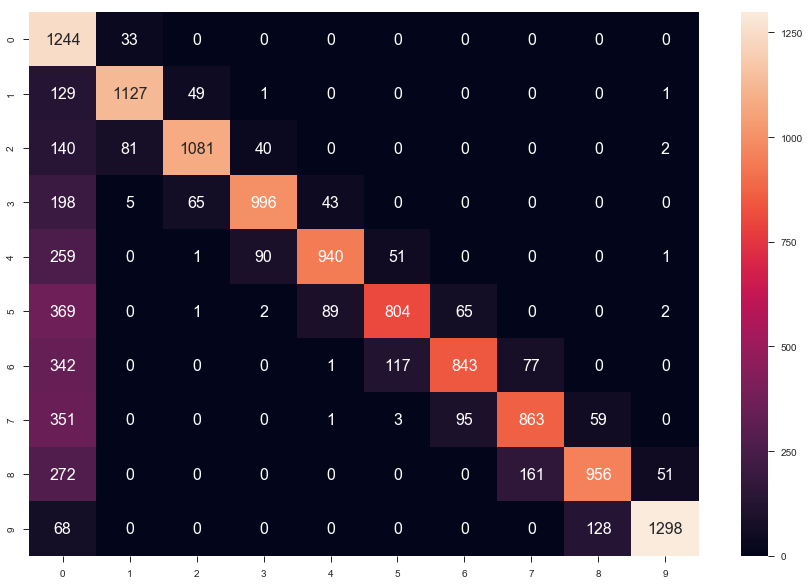

In [45]:
#Create our confusion matrix [object]
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_helmert, axis=1))

#Plot confusion matrix to visualise performance
plt.figure(figsize=(15,10))
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

##### Leave one out encoding

               precision    recall  f1-score   support

       <60kWh       0.96      0.90      0.93      1277
  60kWh-71kWh       0.95      0.75      0.83      1307
  71kWh-81kWh       0.95      0.63      0.76      1344
  81kWh-93kWh       0.93      0.60      0.73      1307
 93kWh-103kWh       0.92      0.51      0.66      1342
103kWh-116kWh       0.88      0.43      0.58      1332
116kWh-128kWh       0.92      0.47      0.62      1380
128kWh-146kWh       0.88      0.52      0.65      1372
146kWh-171kWh       0.89      0.56      0.68      1440
      >171kWh       0.97      0.81      0.88      1494

  avg / total       0.92      0.62      0.73     13595

[[1262   15    0    0    0    0    0    0    0    0]
 [ 315  974   18    0    0    0    0    0    0    0]
 [ 427   36  849   29    1    0    0    0    0    2]
 [ 464    1   30  782   28    2    0    0    0    0]
 [ 598    0    0   30  688   25    0    0    0    1]
 [ 698    0    0    0   25  579   27    0    0    3]
 [ 641    0    0   

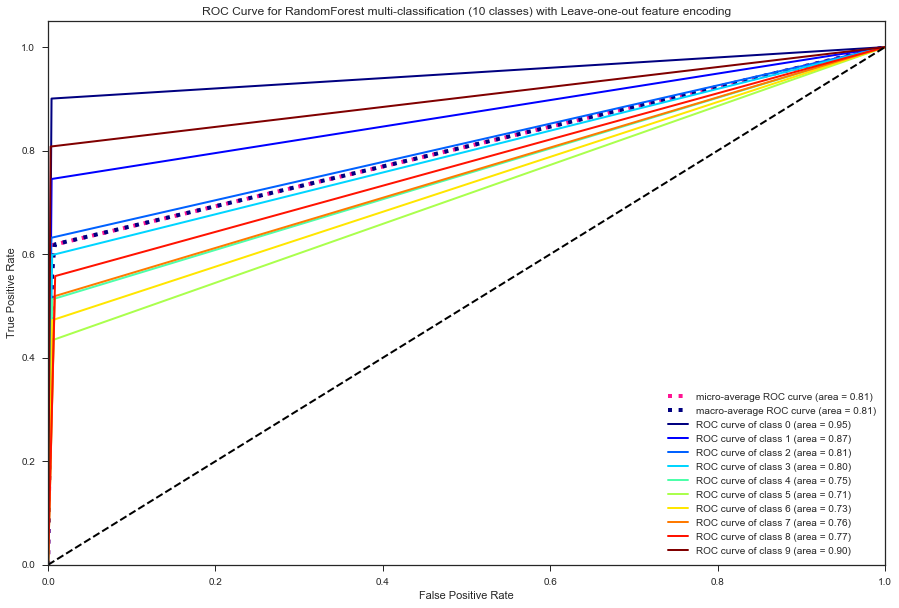

In [47]:
rndForest_lou = forestGrid.best_estimator_
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_lou, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
rndForest_lou.fit(X_train,y_train)
y_pred_lou = rndForest_lou.predict(X_test).astype(np.float)
y_lou_proba = rndForest_lou.predict_proba(X_test)

#Show classification report
print(classification_report(y_test, y_pred_lou, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_lou.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_lou[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_lou.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Leave-one-out feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_LOU_10Classes.png', dpi=200)
plt.show()

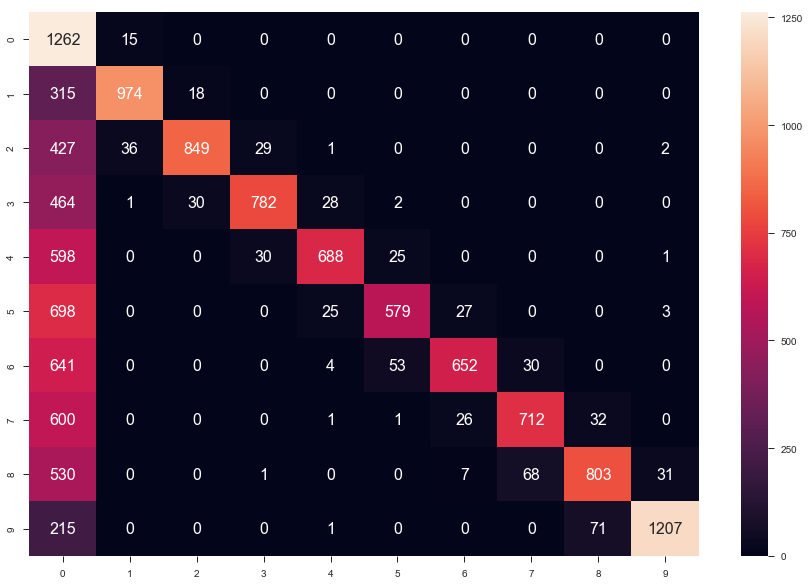

In [49]:
#Create our confusion matrix [object]
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_lou, axis=1))

#Plot confusion matrix to visualise performance
plt.figure(figsize=(15,10))
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

##### One-hot encoding

               precision    recall  f1-score   support

       <60kWh       0.94      0.97      0.96      1277
  60kWh-71kWh       0.89      0.86      0.87      1307
  71kWh-81kWh       0.89      0.79      0.84      1344
  81kWh-93kWh       0.86      0.74      0.80      1307
 93kWh-103kWh       0.84      0.70      0.76      1342
103kWh-116kWh       0.81      0.60      0.69      1332
116kWh-128kWh       0.83      0.60      0.70      1380
128kWh-146kWh       0.77      0.63      0.69      1372
146kWh-171kWh       0.83      0.66      0.73      1440
      >171kWh       0.95      0.86      0.90      1494

  avg / total       0.86      0.74      0.79     13595

[[1245   32    0    0    0    0    0    0    0    0]
 [ 139 1118   47    2    0    0    0    0    0    1]
 [ 124  108 1064   47    0    0    0    0    0    1]
 [ 205    5   76  966   53    2    0    0    0    0]
 [ 250    0    1  103  938   49    0    0    0    1]
 [ 349    0    1    3  116  793   67    0    0    3]
 [ 338    0    0   

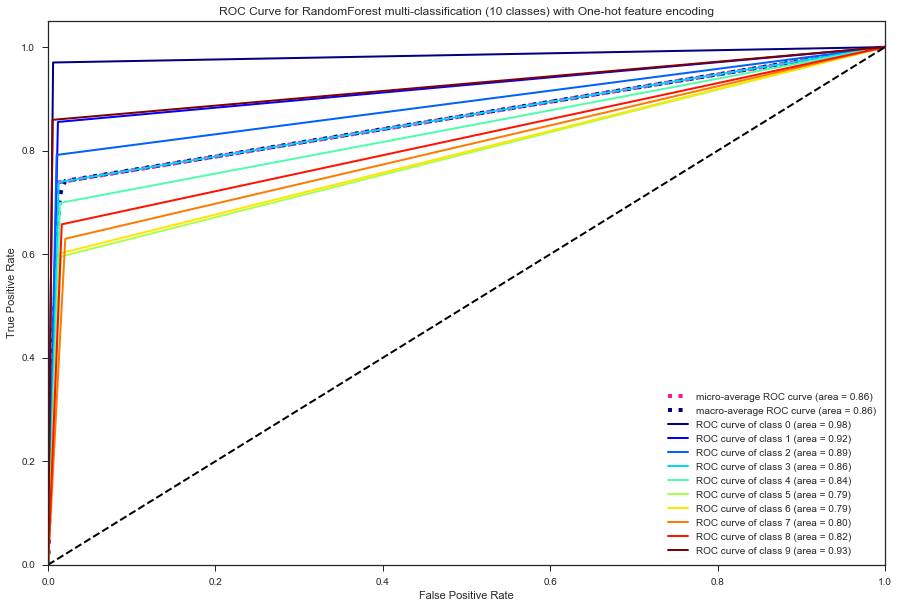

In [50]:
rndForest_onh = forestGrid.best_estimator_
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_onh, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
rndForest_onh.fit(X_train,y_train)
y_pred_onh = rndForest_onh.predict(X_test).astype(np.float)
y_onh_proba = rndForest_onh.predict_proba(X_test)

#Show classification report
print(classification_report(y_test, y_pred_onh, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_onh.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_onh[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_onh.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with One-hot feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_ONH_10Classes.png', dpi=200)
plt.show()

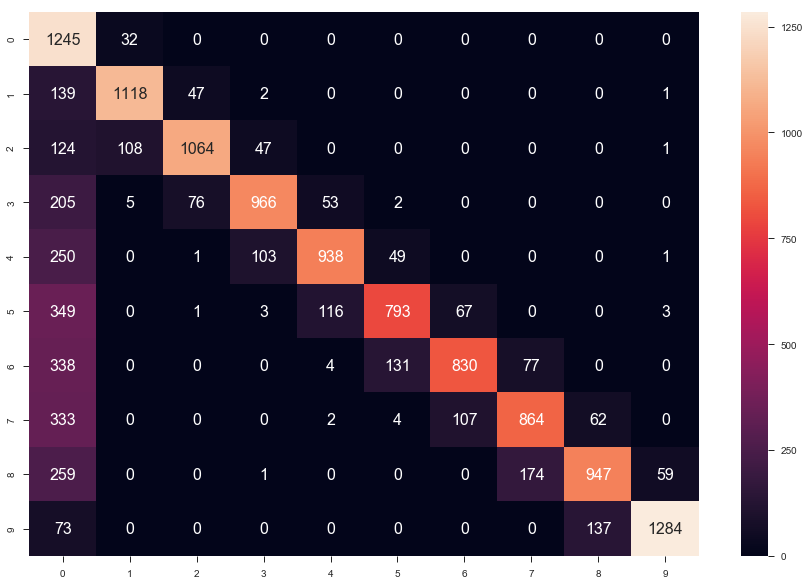

In [51]:
#Create our confusion matrix [object]
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_onh, axis=1))

#Plot confusion matrix to visualise performance
plt.figure(figsize=(15,10))
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

##### Ordinal encoding

               precision    recall  f1-score   support

       <60kWh       0.93      0.91      0.92      1277
  60kWh-71kWh       0.91      0.72      0.80      1307
  71kWh-81kWh       0.95      0.58      0.72      1344
  81kWh-93kWh       0.92      0.53      0.67      1307
 93kWh-103kWh       0.94      0.46      0.62      1342
103kWh-116kWh       0.89      0.40      0.55      1332
116kWh-128kWh       0.93      0.41      0.57      1380
128kWh-146kWh       0.88      0.41      0.56      1372
146kWh-171kWh       0.89      0.48      0.62      1440
      >171kWh       0.96      0.78      0.86      1494

  avg / total       0.92      0.57      0.69     13595

[[1234   43    0    0    0    0    0    0    0    0]
 [ 347  938   22    0    0    0    0    0    0    0]
 [ 498   48  777   19    0    0    0    0    0    2]
 [ 563    6   21  695   22    0    0    0    0    0]
 [ 651    0    1   40  622   27    0    0    0    1]
 [ 756    0    1    3   20  530   17    3    0    2]
 [ 758    0    0   

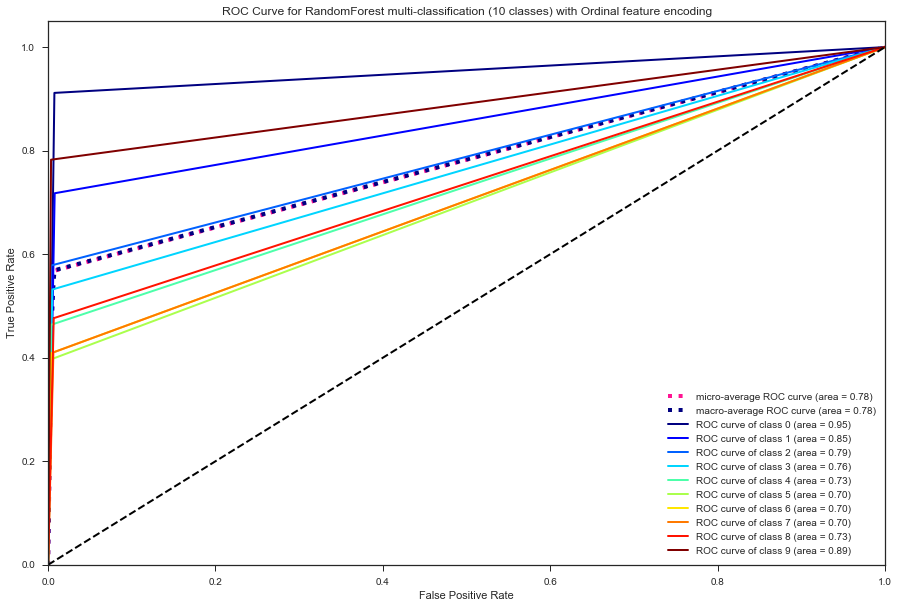

In [52]:
rndForest_ord = forestGrid.best_estimator_
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_ord, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
rndForest_ord.fit(X_train,y_train)
y_pred_ord = rndForest_ord.predict(X_test).astype(np.float)
y_ord_proba = rndForest_ord.predict_proba(X_test)

#Show classification report
print(classification_report(y_test, y_pred_ord, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_ord.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_ord[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_ord.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Ordinal feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Ordinal_10Classes.png', dpi=200)
plt.show()

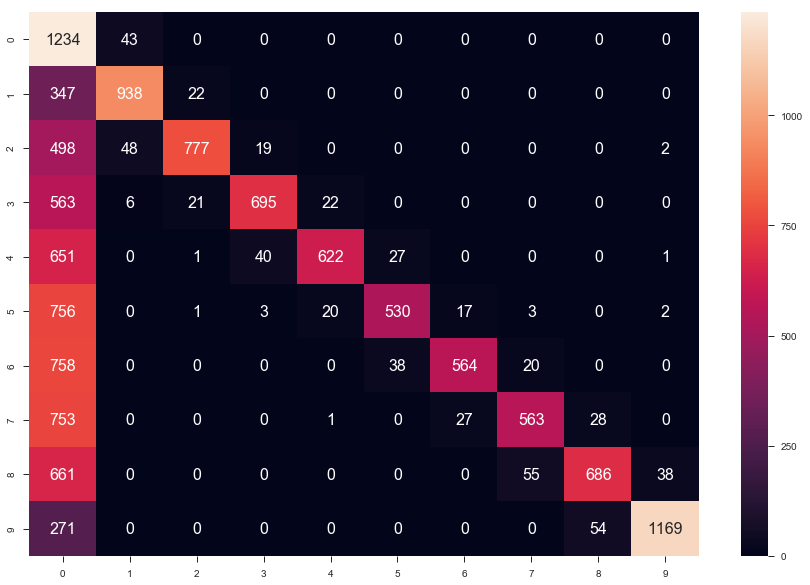

In [53]:
#Create our confusion matrix [object]
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_ord, axis=1))

#Plot confusion matrix to visualise performance
plt.figure(figsize=(15,10))
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

##### Polynomial encoding

               precision    recall  f1-score   support

       <60kWh       0.95      0.96      0.96      1277
  60kWh-71kWh       0.89      0.88      0.88      1307
  71kWh-81kWh       0.91      0.81      0.86      1344
  81kWh-93kWh       0.87      0.77      0.82      1307
 93kWh-103kWh       0.86      0.71      0.78      1342
103kWh-116kWh       0.81      0.62      0.70      1332
116kWh-128kWh       0.83      0.63      0.72      1380
128kWh-146kWh       0.79      0.65      0.71      1372
146kWh-171kWh       0.83      0.68      0.75      1440
      >171kWh       0.95      0.87      0.91      1494

  avg / total       0.87      0.76      0.81     13595

[[1240   37    0    0    0    0    0    0    0    0]
 [ 116 1148   38    1    0    0    0    0    0    4]
 [ 100  103 1093   46    0    1    0    0    0    1]
 [ 172    4   70 1012   46    3    0    0    0    0]
 [ 225    0    2  100  957   57    0    0    0    1]
 [ 315    0    1    3  107  827   76    0    0    3]
 [ 301    0    0   

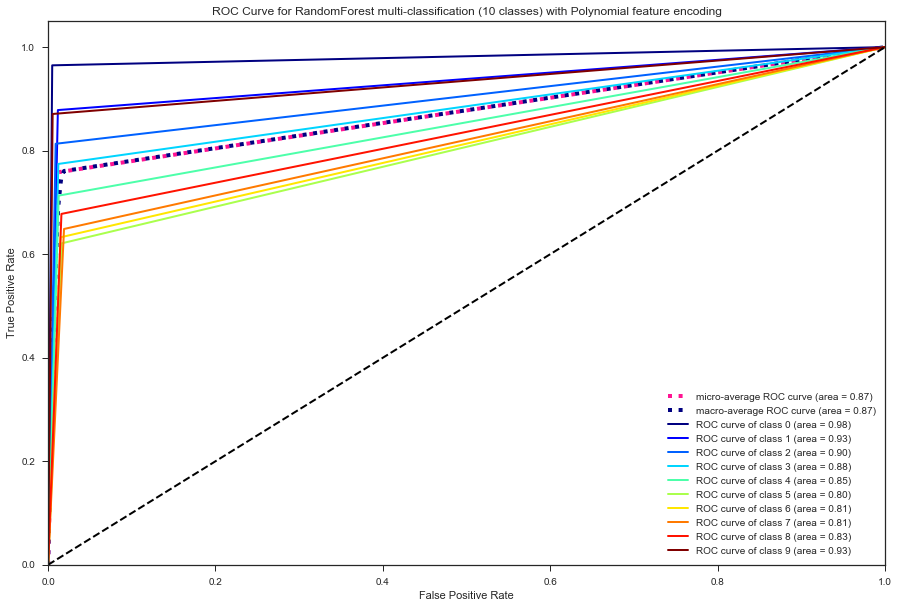

In [54]:
rndForest_poly = forestGrid.best_estimator_
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_poly, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
rndForest_poly.fit(X_train,y_train)
y_pred_poly = rndForest_poly.predict(X_test).astype(np.float)
y_poly_proba = rndForest_poly.predict_proba(X_test)

#Show classification report
print(classification_report(y_test, y_pred_poly, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_poly.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_poly[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_poly.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Polynomial feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Poly_10Classes.png', dpi=200)
plt.show()

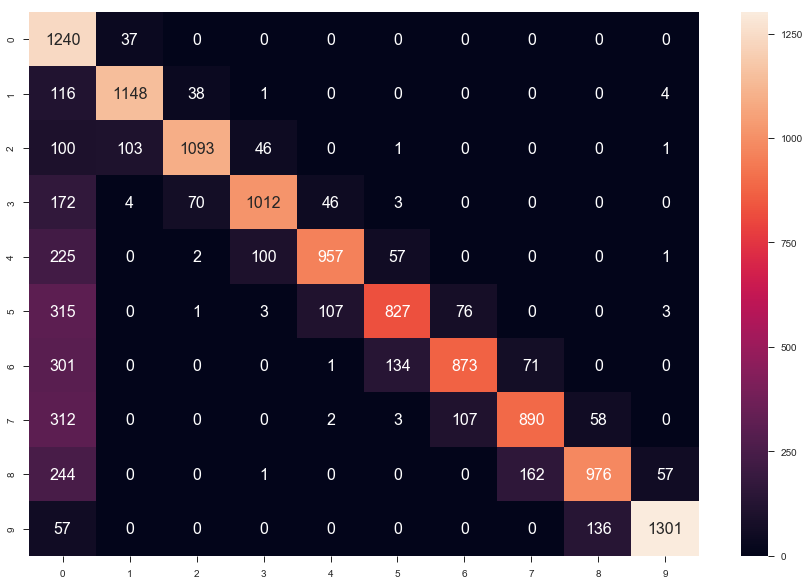

In [55]:
#Create our confusion matrix [object]
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_poly, axis=1))

#Plot confusion matrix to visualise performance
plt.figure(figsize=(15,10))
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

##### Sum encoding

               precision    recall  f1-score   support

       <60kWh       0.95      0.97      0.96      1277
  60kWh-71kWh       0.90      0.87      0.88      1307
  71kWh-81kWh       0.90      0.81      0.85      1344
  81kWh-93kWh       0.88      0.78      0.83      1307
 93kWh-103kWh       0.86      0.72      0.79      1342
103kWh-116kWh       0.81      0.61      0.70      1332
116kWh-128kWh       0.83      0.62      0.71      1380
128kWh-146kWh       0.79      0.65      0.71      1372
146kWh-171kWh       0.83      0.68      0.75      1440
      >171kWh       0.96      0.87      0.91      1494

  avg / total       0.87      0.76      0.81     13595

[[1248   29    0    0    0    0    0    0    0    0]
 [ 127 1140   38    1    0    0    0    0    0    1]
 [ 114   95 1088   47    0    0    0    0    0    0]
 [ 162    6   75 1016   47    1    0    0    0    0]
 [ 229    0    1   89  967   55    0    0    0    1]
 [ 337    0    1    2  101  819   69    0    0    3]
 [ 317    0    0   

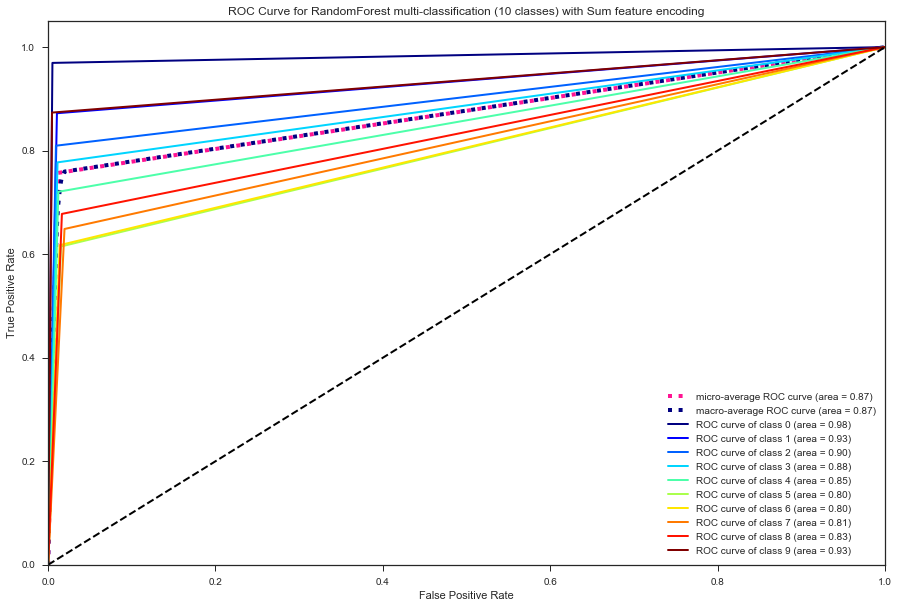

In [56]:
rndForest_sum = forestGrid.best_estimator_
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_sum, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
rndForest_sum.fit(X_train,y_train)
y_pred_sum = rndForest_sum.predict(X_test).astype(np.float)
y_sum_proba = rndForest_sum.predict_proba(X_test)

#Show classification report
print(classification_report(y_test, y_pred_sum, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_sum.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_sum[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_sum.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Sum feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Sum_10Classes.png', dpi=200)
plt.show()

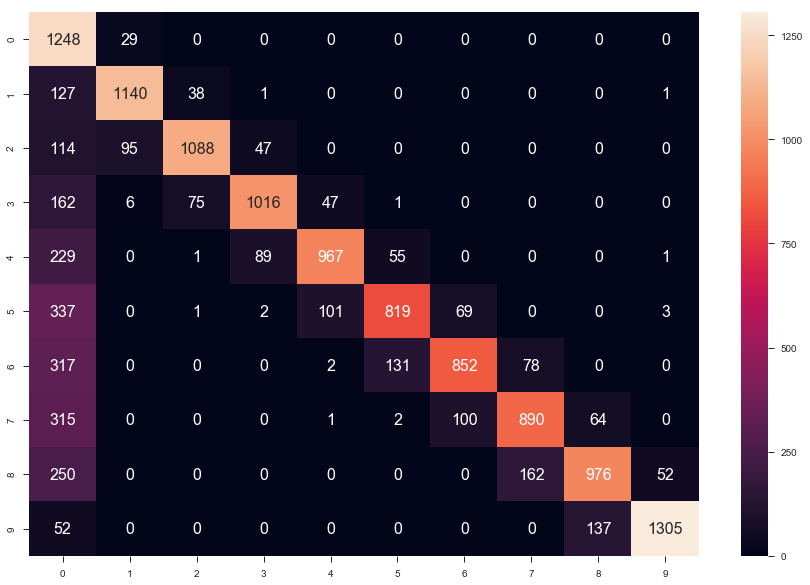

In [57]:
#Create our confusion matrix [object]
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_sum, axis=1))

#Plot confusion matrix to visualise performance
plt.figure(figsize=(15,10))
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

#### Model Stacking 

In [78]:
#Stacking the predictions from all classifiers
y_class_bin = np.empty((len(X_test),1))
y_class_bd = np.empty((len(X_test),1))
y_class_ord = np.empty((len(X_test),1))
y_class_poly = np.empty((len(X_test),1))
y_class_onh = np.empty((len(X_test),1))
y_class_helmert = np.empty((len(X_test),1))
y_class_sum = np.empty((len(X_test),1))
y_class_lou = np.empty((len(X_test),1))
for i in range(0, len(X_test)): 
    y_class_bin[i] = np.argmax(y_pred_bin[i])
    y_class_bd[i] = np.argmax(y_pred_bd[i])
    y_class_ord[i] = np.argmax(y_pred_ord[i])
    y_class_poly[i] = np.argmax(y_pred_poly[i])
    y_class_onh[i] = np.argmax(y_pred_onh[i])
    y_class_helmert[i] = np.argmax(y_pred_helmert[i])
    y_class_sum[i] = np.argmax(y_pred_sum[i])
    y_class_lou[i] = np.argmax(y_pred_lou[i])
    
y_classes_stacked = np.hstack((y_class_bin, y_class_bd, y_class_ord, y_class_poly, y_class_onh, y_class_helmert,
                              y_class_sum, y_class_lou)).astype(int)

y_majvoting = np.empty((len(X_test),1))
for i in range(0, len(X_test)):
    y_majvoting[i] = np.argmax(np.bincount(y_classes_stacked[i]))
    
y_majvoting = label_binarize(y_majvoting, [0,1,2,3,4,5,6,7,8,9])

               precision    recall  f1-score   support

       <60kWh       0.32      0.98      0.48      1277
  60kWh-71kWh       0.91      0.86      0.88      1307
  71kWh-81kWh       0.92      0.78      0.85      1344
  81kWh-93kWh       0.90      0.73      0.81      1307
 93kWh-103kWh       0.89      0.67      0.76      1342
103kWh-116kWh       0.85      0.56      0.67      1332
116kWh-128kWh       0.88      0.57      0.69      1380
128kWh-146kWh       0.82      0.60      0.69      1372
146kWh-171kWh       0.86      0.65      0.74      1440
      >171kWh       0.96      0.86      0.91      1494

  avg / total       0.84      0.72      0.75     13595

[[1251   26    0    0    0    0    0    0    0    0]
 [ 152 1120   34    1    0    0    0    0    0    0]
 [ 177   81 1049   35    0    0    0    0    0    2]
 [ 256    4   53  959   35    0    0    0    0    0]
 [ 338    0    1   69  896   37    0    0    0    1]
 [ 467    0    1    2   71  746   43    0    0    2]
 [ 452    0    0   

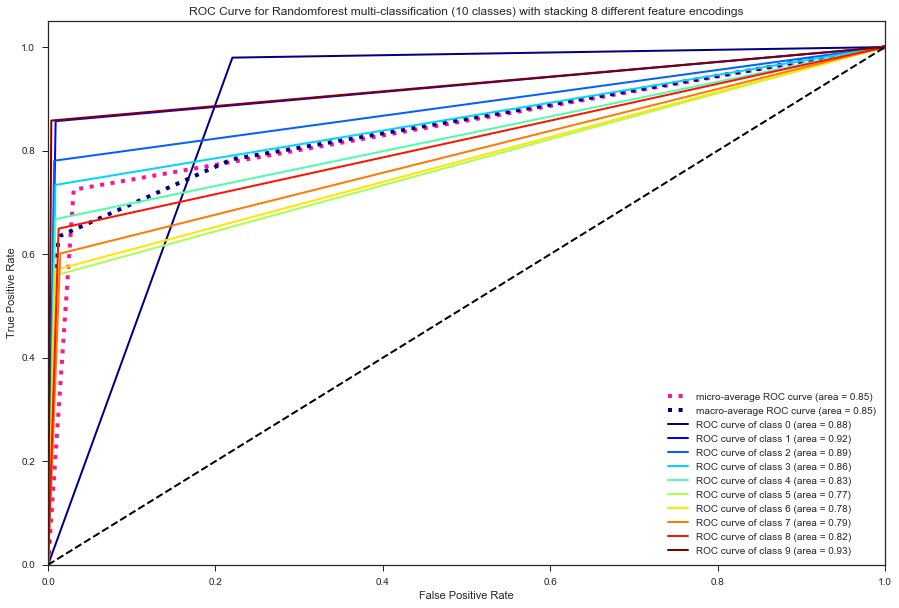

In [83]:
#Show classification report
print(classification_report(y_test, y_majvoting, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_majvoting.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_majvoting[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_majvoting.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Randomforest multi-classification (10 classes) with stacking 8 different feature encodings')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Stacking_10Classes.png', dpi=200)
plt.show()

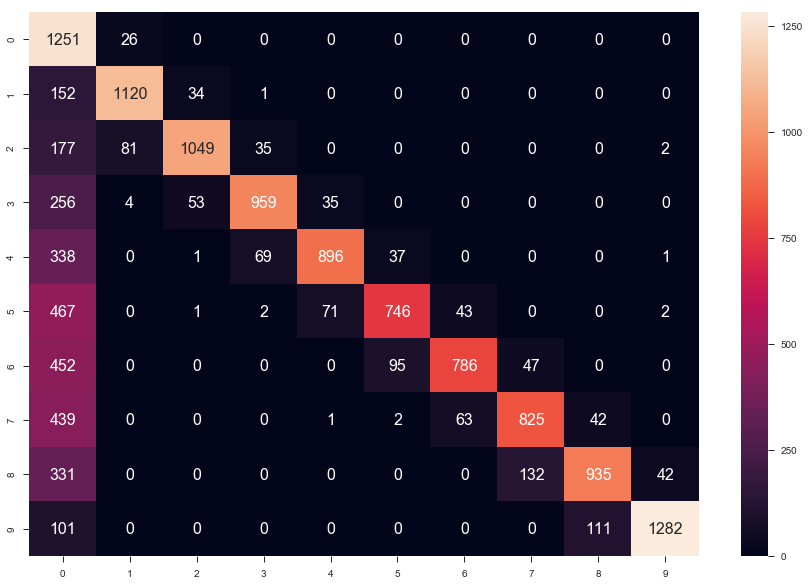

In [84]:
#Create our confusion matrix [object]
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_majvoting, axis=1))

#Plot confusion matrix to visualise performance
plt.figure(figsize=(15,10))
sns.heatmap(cm, fmt='d', annot=True,annot_kws={"size": 16})# font size
plt.show()

### Practice

#### ExtraTrees Classifier

In [332]:
extrForest = ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1337, verbose=0,
            warm_start=False)

               precision    recall  f1-score   support

       <60kWh       0.96      0.95      0.96      1277
  60kWh-71kWh       0.93      0.82      0.87      1307
  71kWh-81kWh       0.93      0.75      0.83      1344
  81kWh-93kWh       0.91      0.69      0.78      1307
 93kWh-103kWh       0.90      0.62      0.73      1342
103kWh-116kWh       0.88      0.52      0.65      1332
116kWh-128kWh       0.89      0.54      0.68      1380
128kWh-146kWh       0.83      0.55      0.66      1372
146kWh-171kWh       0.88      0.59      0.71      1440
      >171kWh       0.97      0.85      0.90      1494

  avg / total       0.91      0.69      0.78     13595

[[1250   27    0    0    0    0    0    0    0    0]
 [ 199 1073   34    1    0    0    0    0    0    0]
 [ 241   56 1009   36    0    0    0    0    0    2]
 [ 320    2   41  899   45    0    0    0    0    0]
 [ 417    0    1   54  828   41    0    0    0    1]
 [ 546    0    1    0   41  690   52    0    0    2]
 [ 524    0    0   

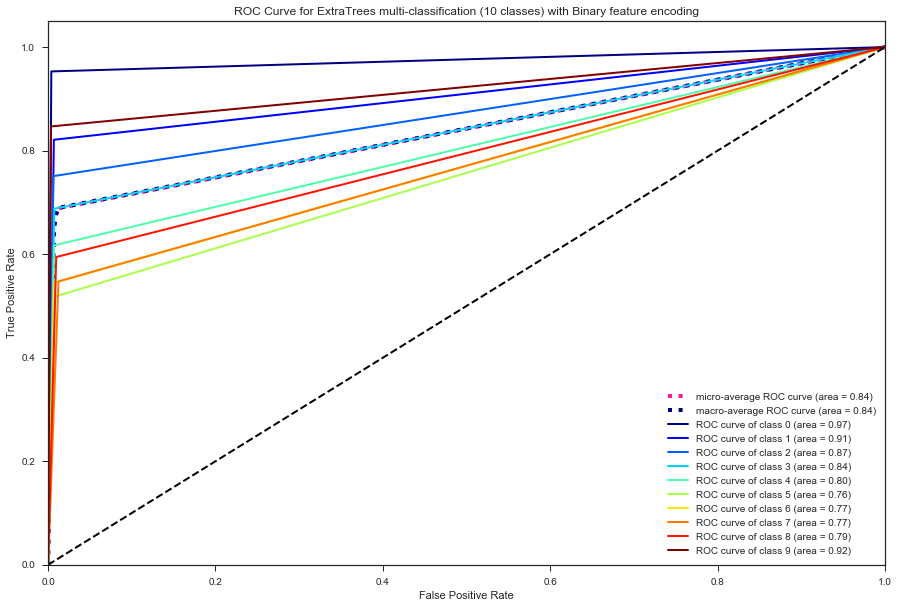

In [346]:
extrForest_bin = extrForest
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_bin, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
extrForest_bin.fit(X_train,y_train)
y_pred_bin = extrForest_bin.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_bin, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_bin.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ExtraTrees multi-classification (10 classes) with Binary feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Binary_10Classes.png', dpi=200)
plt.show()

               precision    recall  f1-score   support

       <60kWh       0.96      0.95      0.96      1277
  60kWh-71kWh       0.93      0.82      0.87      1307
  71kWh-81kWh       0.93      0.75      0.83      1344
  81kWh-93kWh       0.91      0.69      0.78      1307
 93kWh-103kWh       0.90      0.62      0.73      1342
103kWh-116kWh       0.88      0.52      0.65      1332
116kWh-128kWh       0.89      0.54      0.68      1380
128kWh-146kWh       0.83      0.55      0.66      1372
146kWh-171kWh       0.88      0.59      0.71      1440
      >171kWh       0.97      0.85      0.90      1494

  avg / total       0.91      0.69      0.78     13595

[[1246   31    0    0    0    0    0    0    0    0]
 [ 180 1091   35    1    0    0    0    0    0    0]
 [ 220   67 1019   37    0    0    0    0    0    1]
 [ 311    1   46  908   41    0    0    0    0    0]
 [ 402    0    1   55  842   41    0    0    0    1]
 [ 522    0    1    2   50  704   50    0    0    3]
 [ 505    0    0   

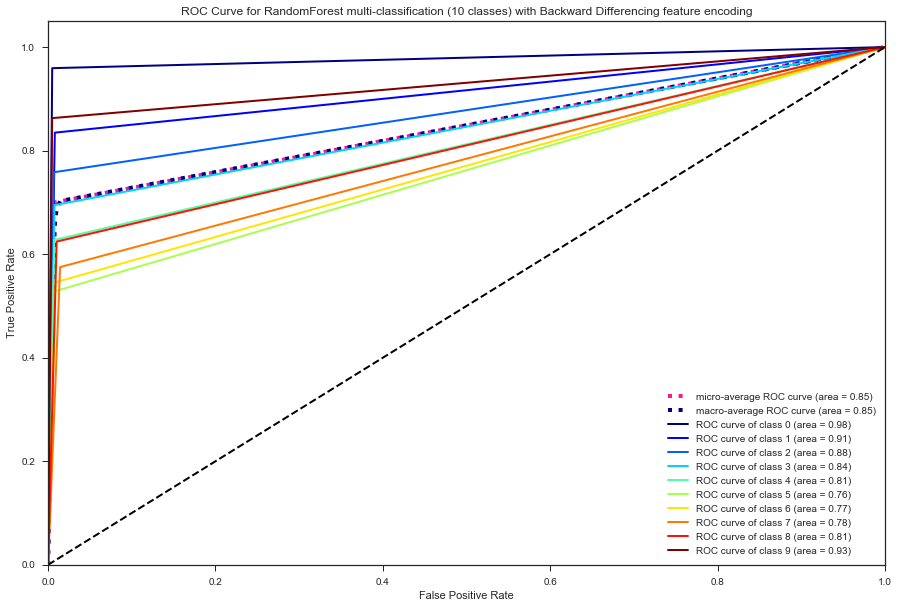

In [347]:
extrForest_bd = extrForest
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_bd, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
extrForest_bd.fit(X_train,y_train)
y_pred_bd = extrForest_bd.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_bin, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_bd.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_bd[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_bd.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Backward Differencing feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_BackDiff_10Classes.png', dpi=200)
plt.show()

               precision    recall  f1-score   support

       <60kWh       0.96      0.96      0.96      1277
  60kWh-71kWh       0.91      0.85      0.88      1307
  71kWh-81kWh       0.92      0.78      0.84      1344
  81kWh-93kWh       0.90      0.74      0.81      1307
 93kWh-103kWh       0.89      0.67      0.77      1342
103kWh-116kWh       0.84      0.57      0.68      1332
116kWh-128kWh       0.87      0.59      0.70      1380
128kWh-146kWh       0.81      0.61      0.70      1372
146kWh-171kWh       0.85      0.64      0.73      1440
      >171kWh       0.94      0.87      0.91      1494

  avg / total       0.89      0.73      0.80     13595

[[1244   33    0    0    0    0    0    0    0    0]
 [ 144 1112   46    1    0    0    0    0    0    4]
 [ 169   78 1051   45    0    0    0    0    0    1]
 [ 236    3   48  971   49    0    0    0    0    0]
 [ 317    0    1   63  904   55    0    0    1    1]
 [ 441    0    1    2   62  761   63    0    0    2]
 [ 406    0    0   

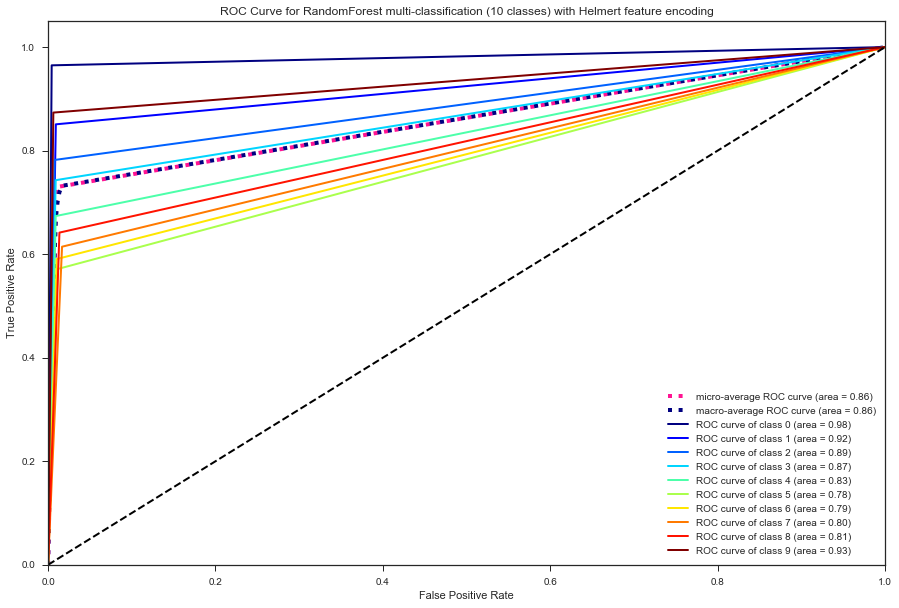

In [348]:
extrForest_helmert = extrForest
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_helmert, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
extrForest_helmert.fit(X_train,y_train)
y_pred_helmert = extrForest_helmert.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_helmert, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_helmert.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_helmert[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_helmert.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Helmert feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Helmert_10Classes.png', dpi=200)
plt.show()

               precision    recall  f1-score   support

       <60kWh       0.95      0.89      0.92      1277
  60kWh-71kWh       0.96      0.67      0.79      1307
  71kWh-81kWh       0.95      0.56      0.71      1344
  81kWh-93kWh       0.94      0.53      0.68      1307
 93kWh-103kWh       0.93      0.47      0.62      1342
103kWh-116kWh       0.90      0.38      0.53      1332
116kWh-128kWh       0.95      0.42      0.58      1380
128kWh-146kWh       0.89      0.47      0.61      1372
146kWh-171kWh       0.90      0.50      0.64      1440
      >171kWh       0.97      0.78      0.86      1494

  avg / total       0.93      0.57      0.70     13595

[[1261   15    1    0    0    0    0    0    0    0]
 [ 417  881    9    0    0    0    0    0    0    0]
 [ 547   20  752   24    0    0    0    0    0    1]
 [ 561    0   26  696   24    0    0    0    0    0]
 [ 663    0    0   21  633   24    0    0    0    1]
 [ 790    0    0    0   21  504   13    1    0    3]
 [ 742    0    1   

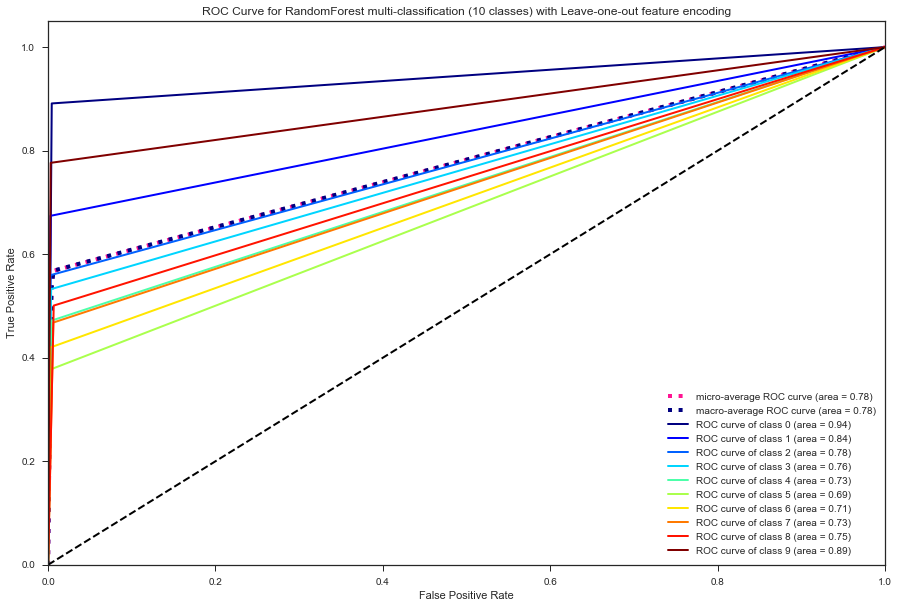

In [349]:
extrForest_lou = extrForest
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_lou, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
extrForest_lou.fit(X_train,y_train)
y_pred_lou = extrForest_lou.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_lou, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_lou.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_lou[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_lou.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Leave-one-out feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_LOU_10Classes.png', dpi=200)
plt.show()

               precision    recall  f1-score   support

       <60kWh       0.96      0.96      0.96      1277
  60kWh-71kWh       0.89      0.85      0.87      1307
  71kWh-81kWh       0.89      0.77      0.83      1344
  81kWh-93kWh       0.87      0.72      0.79      1307
 93kWh-103kWh       0.86      0.67      0.75      1342
103kWh-116kWh       0.82      0.57      0.67      1332
116kWh-128kWh       0.84      0.59      0.69      1380
128kWh-146kWh       0.78      0.61      0.68      1372
146kWh-171kWh       0.82      0.64      0.72      1440
      >171kWh       0.94      0.86      0.90      1494

  avg / total       0.87      0.72      0.79     13595

[[1236   41    0    0    0    0    0    0    0    0]
 [ 137 1108   58    1    0    0    0    0    0    3]
 [ 154   89 1040   59    0    0    0    0    0    2]
 [ 227    2   69  942   67    0    0    0    0    0]
 [ 297    0    1   82  897   64    0    0    0    1]
 [ 415    0    1    1   81  755   76    0    0    3]
 [ 395    0    0   

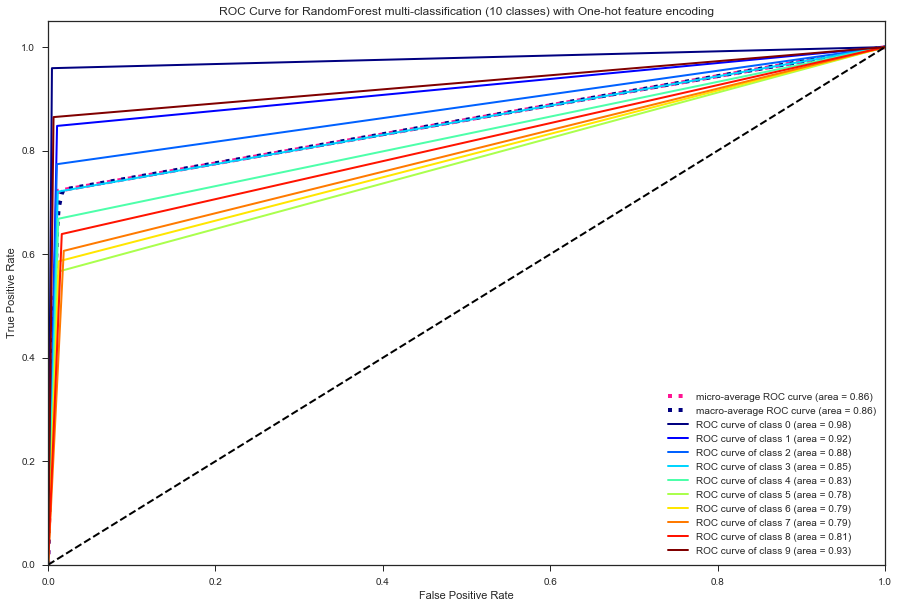

In [350]:
extrForest_onh = extrForest
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_onh, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
extrForest_onh.fit(X_train,y_train)
y_pred_onh = extrForest_onh.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_onh, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_onh.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_onh[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_onh.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with One-hot feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_ONH_10Classes.png', dpi=200)
plt.show()

               precision    recall  f1-score   support

       <60kWh       0.94      0.93      0.94      1277
  60kWh-71kWh       0.94      0.68      0.79      1307
  71kWh-81kWh       0.96      0.56      0.71      1344
  81kWh-93kWh       0.94      0.47      0.63      1307
 93kWh-103kWh       0.95      0.39      0.56      1342
103kWh-116kWh       0.94      0.35      0.51      1332
116kWh-128kWh       0.97      0.36      0.53      1380
128kWh-146kWh       0.93      0.34      0.50      1372
146kWh-171kWh       0.94      0.41      0.57      1440
      >171kWh       0.98      0.76      0.85      1494

  avg / total       0.95      0.52      0.66     13595

[[1254   23    0    0    0    0    0    0    0    0]
 [ 401  887   19    0    0    0    0    0    0    0]
 [ 548   30  753   11    0    0    0    0    0    2]
 [ 660    1   14  614   18    0    0    0    0    0]
 [ 771    0    0   25  529   16    0    0    0    1]
 [ 849    0    0    0    8  462   11    0    0    2]
 [ 860    0    0   

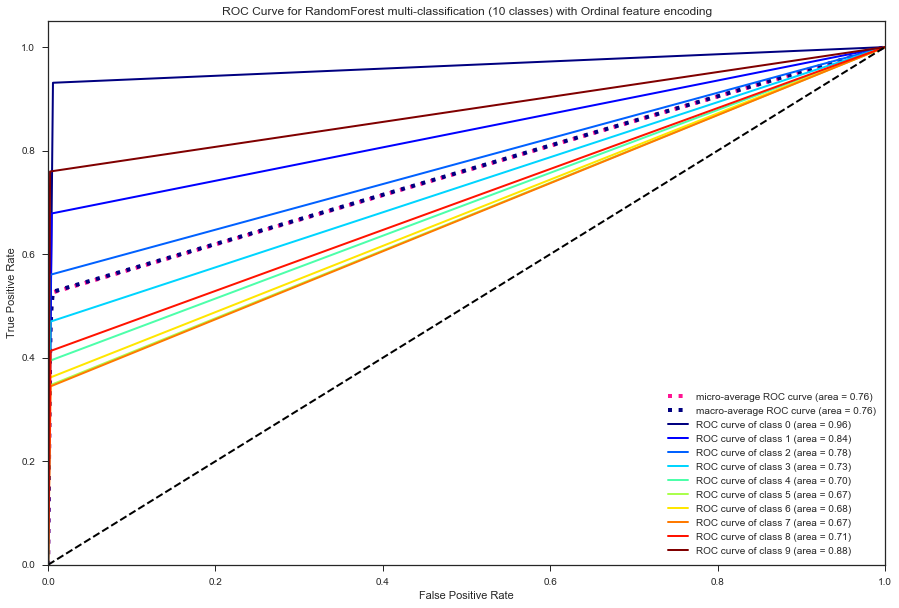

In [351]:
extrForest_ord = extrForest
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_ord, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
extrForest_ord.fit(X_train,y_train)
y_pred_ord = extrForest_ord.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_ord, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_ord.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_ord[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_ord.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Ordinal feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Ordinal_10Classes.png', dpi=200)
plt.show()

               precision    recall  f1-score   support

       <60kWh       0.96      0.96      0.96      1277
  60kWh-71kWh       0.90      0.85      0.88      1307
  71kWh-81kWh       0.91      0.77      0.84      1344
  81kWh-93kWh       0.88      0.74      0.80      1307
 93kWh-103kWh       0.88      0.69      0.78      1342
103kWh-116kWh       0.83      0.59      0.69      1332
116kWh-128kWh       0.86      0.60      0.70      1380
128kWh-146kWh       0.81      0.63      0.71      1372
146kWh-171kWh       0.83      0.64      0.73      1440
      >171kWh       0.94      0.87      0.90      1494

  avg / total       0.88      0.73      0.80     13595

[[1244   33    0    0    0    0    0    0    0    0]
 [ 136 1115   49    2    0    0    0    0    0    5]
 [ 157   89 1041   53    0    2    0    0    0    2]
 [ 230    2   49  966   59    1    0    0    0    0]
 [ 276    0    1   70  930   64    0    0    0    1]
 [ 411    0    1    2   64  784   67    0    0    3]
 [ 388    0    0   

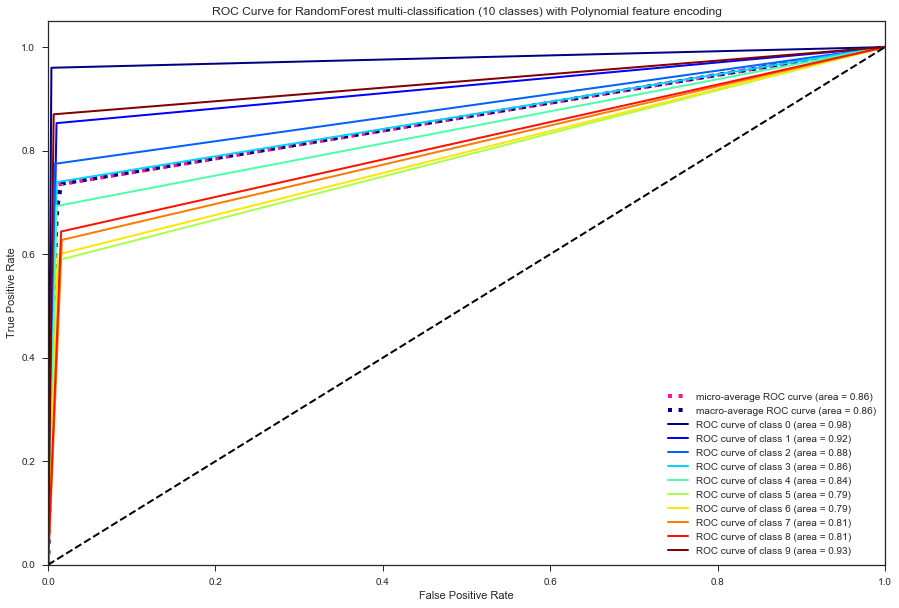

In [352]:
extrForest_poly = extrForest
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_poly, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
extrForest_poly.fit(X_train,y_train)
y_pred_poly = extrForest_poly.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_poly, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_poly.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_poly[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_poly.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Polynomial feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Poly_10Classes.png', dpi=200)
plt.show()

               precision    recall  f1-score   support

       <60kWh       0.95      0.96      0.96      1277
  60kWh-71kWh       0.92      0.86      0.89      1307
  71kWh-81kWh       0.91      0.79      0.85      1344
  81kWh-93kWh       0.88      0.74      0.81      1307
 93kWh-103kWh       0.88      0.69      0.77      1342
103kWh-116kWh       0.84      0.59      0.69      1332
116kWh-128kWh       0.86      0.60      0.70      1380
128kWh-146kWh       0.79      0.62      0.70      1372
146kWh-171kWh       0.83      0.64      0.72      1440
      >171kWh       0.94      0.87      0.91      1494

  avg / total       0.88      0.74      0.80     13595

[[1247   30    0    0    0    0    0    0    0    0]
 [ 138 1118   48    1    0    0    0    0    0    2]
 [ 159   68 1065   50    0    0    0    0    0    2]
 [ 229    3   53  969   53    0    0    0    0    0]
 [ 283    0    1   74  925   58    0    0    0    1]
 [ 410    0    1    1   73  780   64    0    0    3]
 [ 389    0    0   

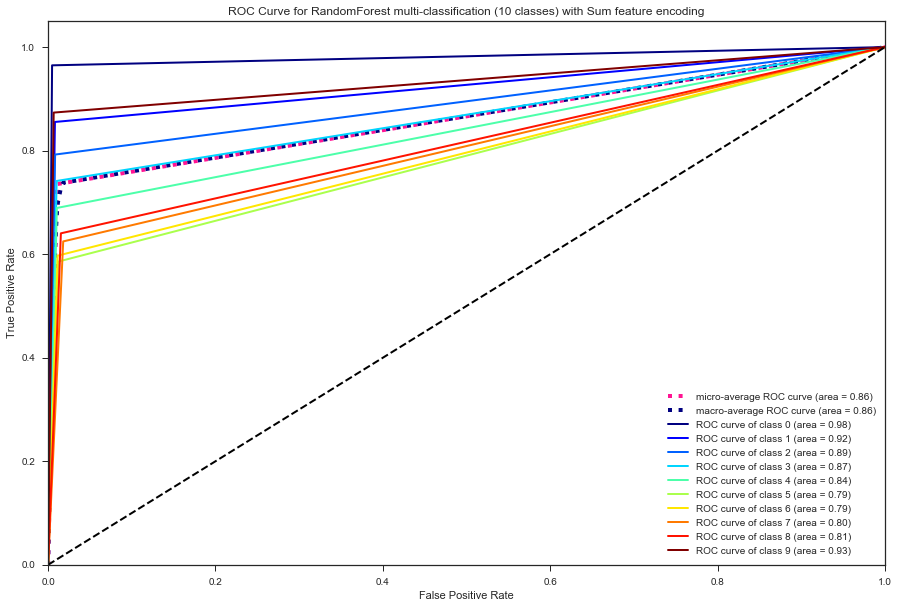

In [353]:
extrForest_sum = extrForest
#Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(Results_sum, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
extrForest_sum.fit(X_train,y_train)
y_pred_sum = extrForest_sum.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_sum, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_sum.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_sum[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_sum.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for RandomForest multi-classification (10 classes) with Sum feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Sum_10Classes.png', dpi=200)
plt.show()

In [354]:
#Stacking the predictions from all classifiers
y_class_bin = np.empty((len(X_test),1))
y_class_bd = np.empty((len(X_test),1))
y_class_ord = np.empty((len(X_test),1))
y_class_poly = np.empty((len(X_test),1))
y_class_onh = np.empty((len(X_test),1))
y_class_helmert = np.empty((len(X_test),1))
y_class_sum = np.empty((len(X_test),1))
y_class_lou = np.empty((len(X_test),1))
for i in range(0, len(X_test)): 
    y_class_bin[i] = np.argmax(y_pred_bin[i])
    y_class_bd[i] = np.argmax(y_pred_bd[i])
    y_class_ord[i] = np.argmax(y_pred_ord[i])
    y_class_poly[i] = np.argmax(y_pred_poly[i])
    y_class_onh[i] = np.argmax(y_pred_onh[i])
    y_class_helmert[i] = np.argmax(y_pred_helmert[i])
    y_class_sum[i] = np.argmax(y_pred_sum[i])
    y_class_lou[i] = np.argmax(y_pred_lou[i])
    
y_classes_stacked = np.hstack((y_class_bin, y_class_bd, y_class_ord, y_class_poly, y_class_onh, y_class_helmert,
                              y_class_sum, y_class_lou)).astype(int)

y_majvoting_extr = np.empty((len(X_test),1))
for i in range(0, len(X_test)):
    y_majvoting_extr[i] = np.argmax(np.bincount(y_classes_stacked[i]))
    
y_majvoting_extr = label_binarize(y_majvoting, [0,1,2,3,4,5,6,7,8,9])

               precision    recall  f1-score   support

       <60kWh       0.32      0.98      0.48      1277
  60kWh-71kWh       0.91      0.86      0.88      1307
  71kWh-81kWh       0.92      0.78      0.85      1344
  81kWh-93kWh       0.90      0.73      0.81      1307
 93kWh-103kWh       0.89      0.67      0.76      1342
103kWh-116kWh       0.85      0.56      0.67      1332
116kWh-128kWh       0.88      0.57      0.69      1380
128kWh-146kWh       0.82      0.60      0.69      1372
146kWh-171kWh       0.86      0.65      0.74      1440
      >171kWh       0.96      0.86      0.91      1494

  avg / total       0.84      0.72      0.75     13595

[[1251   26    0    0    0    0    0    0    0    0]
 [ 152 1120   34    1    0    0    0    0    0    0]
 [ 177   81 1049   35    0    0    0    0    0    2]
 [ 256    4   53  959   35    0    0    0    0    0]
 [ 338    0    1   69  896   37    0    0    0    1]
 [ 467    0    1    2   71  746   43    0    0    2]
 [ 452    0    0   

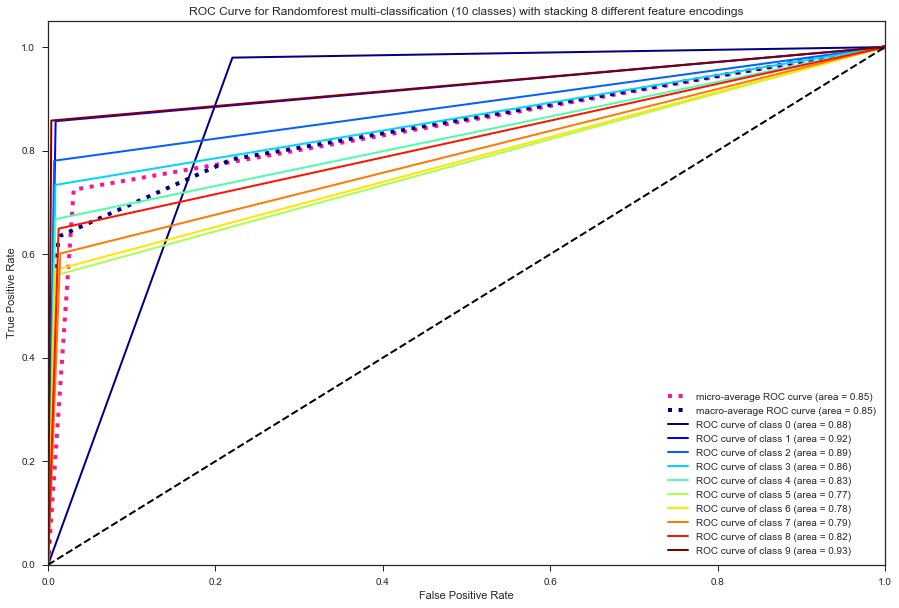

In [356]:
#Show classification report
print(classification_report(y_test, y_majvoting_extr, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_majvoting_extr.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_majvoting_extr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_majvoting_extr.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Randomforest multi-classification (10 classes) with stacking 8 different feature encodings')
plt.legend(loc="lower right")
plt.savefig('ROC_RF_Stacking_10Classes.png', dpi=200)
plt.show()

#### GradientBoosting Classifier

In [372]:
#Run grid search for GBM Classifier
from sklearn.multiclass import OneVsRestClassifier

estimator = OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100))

param_grid = {
    'estimator__learning_rate': [0.01, 0.3, 0.8],
    'estimator__max_depth': [None, 3, 6, 12],
    'estimator__min_samples_split': [2, 4, 8],
    'estimator__min_samples_leaf': [1, 3, 5],
    'estimator__loss': ['deviance', 'exponential']
}

boostGrid = GridSearchCV(estimator, param_grid=param_grid, cv=3, verbose=3, n_jobs=4)

#X_train, X_test, y_train, y_test = train_test_split(Results_bin, y_classes_labeled, test_size=0.333, random_state=1337)
#y_train = y_train.ravel().astype('float32')
#y_test = y_test.ravel().astype('float32')

boostGrid.fit(Results_sum, y_classes)
#Save model to disk
joblib.dump(boostGrid.best_estimator_, 'GBMGridClassification.pkl')
print(boostGrid.best_estimator_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 19.8min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 51.5min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 97.7min
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed: 175.9min
[Parallel(n_jobs=4)]: Done 648 out of 648 | elapsed: 208.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
             ...', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          n_jobs=1),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'estimator__learning_rate': [0.01, 0.3, 0.8], 'estimator__max_depth': [None, 3, 6, 12], 'estimator__min_samples_split': [2, 4, 8], 'estimator__min_samples_leaf': [1, 3, 5], 'estimator__loss': ['deviance', 'exponential']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

               precision    recall  f1-score   support

       <60kWh       0.97      0.97      0.97      1277
  60kWh-71kWh       0.90      0.91      0.91      1307
  71kWh-81kWh       0.90      0.89      0.89      1344
  81kWh-93kWh       0.88      0.86      0.87      1307
 93kWh-103kWh       0.83      0.80      0.82      1342
103kWh-116kWh       0.79      0.74      0.76      1332
116kWh-128kWh       0.77      0.70      0.73      1380
128kWh-146kWh       0.78      0.74      0.76      1372
146kWh-171kWh       0.84      0.79      0.81      1440
      >171kWh       0.95      0.94      0.94      1494

  avg / total       0.86      0.83      0.85     13595

[[1244   33    0    0    0    0    0    0    0    0]
 [  80 1186   39    1    0    1    0    0    0    0]
 [  60   70 1173   40    1    0    0    0    0    0]
 [  83    0   68 1109   46    1    0    0    0    0]
 [ 134    0    4   65 1065   72    2    0    0    0]
 [ 174    0    0    3  119  948   86    2    0    0]
 [ 187    0    0   

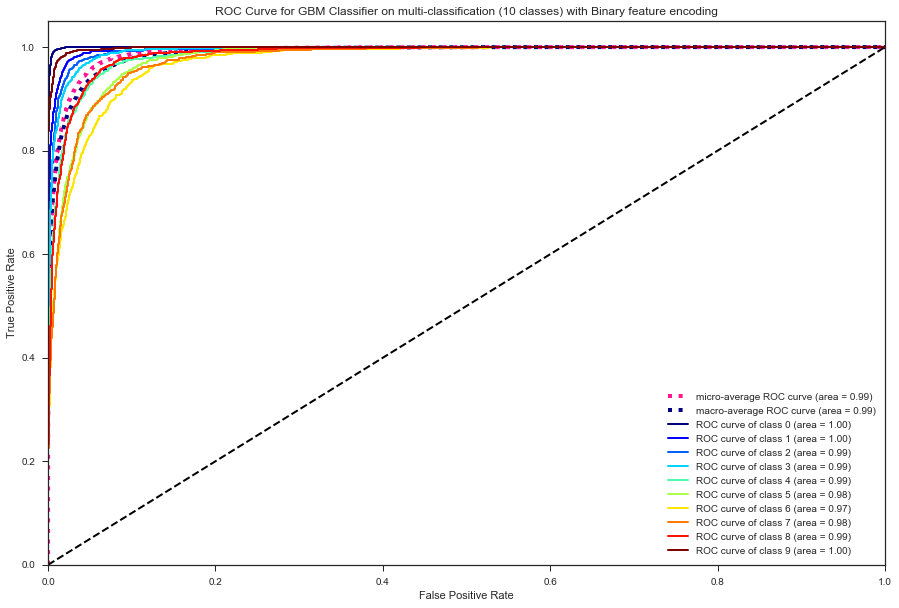

In [398]:
#Binary feature encoding
grdBoosting_bin = OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=6, max_features=None, max_leaf_nodes=None, 
              min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=5, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=1000, presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), n_jobs=6)

X_train, X_test, y_train, y_test = train_test_split(Results_bin, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
grdBoosting_bin.fit(X_train,y_train)
y_score_bin = grdBoosting_bin.decision_function(X_test)
y_pred_bin = grdBoosting_bin.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_bin, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_bin.argmax(axis=1)))

# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Classifier on multi-classification (10 classes) with Binary feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_GBM_Bin_10Classes.png', dpi=200)
plt.show()

               precision    recall  f1-score   support

       <60kWh       0.98      0.96      0.97      1277
  60kWh-71kWh       0.90      0.92      0.91      1307
  71kWh-81kWh       0.89      0.90      0.90      1344
  81kWh-93kWh       0.90      0.88      0.89      1307
 93kWh-103kWh       0.83      0.83      0.83      1342
103kWh-116kWh       0.80      0.77      0.79      1332
116kWh-128kWh       0.79      0.74      0.76      1380
128kWh-146kWh       0.80      0.78      0.79      1372
146kWh-171kWh       0.83      0.82      0.83      1440
      >171kWh       0.95      0.95      0.95      1494

  avg / total       0.87      0.85      0.86     13595

[[1236   40    0    0    0    1    0    0    0    0]
 [  71 1195   41    0    0    0    0    0    0    0]
 [  51   72 1182   39    0    0    0    0    0    0]
 [  45    1   67 1139   53    2    0    0    0    0]
 [ 104    0    4   64 1106   63    0    1    0    0]
 [ 124    0    0    4  121  993   87    3    0    0]
 [ 152    0    0   

AttributeError: 'itertools.cycle' object has no attribute 'Normalize'

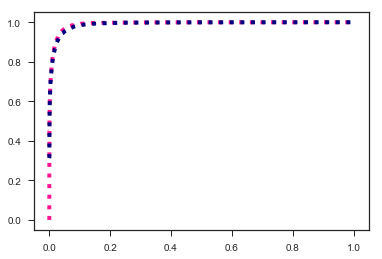

In [392]:
grdBoosting_sum = OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=6, max_features=None, max_leaf_nodes=None, 
              min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=5, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=1000, presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), n_jobs=6)

X_train, X_test, y_train, y_test = train_test_split(Results_sum, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
grdBoosting_sum.fit(X_train,y_train)
y_score_sum = grdBoosting_sum.decision_function(X_test)
y_pred_sum = grdBoosting_sum.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_sum, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_sum.argmax(axis=1)))

In [400]:
grdBoosting_ord = OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=6, max_features=None, max_leaf_nodes=None, 
              min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=5, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=1000, presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), n_jobs=6)

X_train, X_test, y_train, y_test = train_test_split(Results_ord, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
grdBoosting_ord.fit(X_train,y_train)
y_score_ord = grdBoosting_ord.decision_function(X_test)
y_pred_ord = grdBoosting_ord.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_ord, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_ord.argmax(axis=1)))

               precision    recall  f1-score   support

       <60kWh       0.97      0.97      0.97      1277
  60kWh-71kWh       0.90      0.92      0.91      1307
  71kWh-81kWh       0.89      0.88      0.89      1344
  81kWh-93kWh       0.88      0.85      0.86      1307
 93kWh-103kWh       0.83      0.79      0.81      1342
103kWh-116kWh       0.80      0.73      0.76      1332
116kWh-128kWh       0.77      0.70      0.74      1380
128kWh-146kWh       0.77      0.75      0.76      1372
146kWh-171kWh       0.83      0.81      0.82      1440
      >171kWh       0.95      0.94      0.94      1494

  avg / total       0.86      0.83      0.85     13595

[[1240   37    0    0    0    0    0    0    0    0]
 [  73 1189   43    0    1    1    0    0    0    0]
 [  62   77 1164   39    2    0    0    0    0    0]
 [  84    2   74 1095   51    0    1    0    0    0]
 [ 127    0    4   87 1051   71    1    1    0    0]
 [ 167    0    0    3  115  950   91    4    2    0]
 [ 191    0    0   

In [401]:
grdBoosting_poly = OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=6, max_features=None, max_leaf_nodes=None, 
              min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=5, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=1000, presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), n_jobs=6)

X_train, X_test, y_train, y_test = train_test_split(Results_poly, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
grdBoosting_poly.fit(X_train,y_train)
y_score_poly = grdBoosting_poly.decision_function(X_test)
y_pred_poly = grdBoosting_poly.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_poly, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_poly.argmax(axis=1)))

               precision    recall  f1-score   support

       <60kWh       0.98      0.97      0.97      1277
  60kWh-71kWh       0.87      0.92      0.89      1307
  71kWh-81kWh       0.89      0.90      0.90      1344
  81kWh-93kWh       0.89      0.88      0.89      1307
 93kWh-103kWh       0.84      0.83      0.83      1342
103kWh-116kWh       0.81      0.77      0.79      1332
116kWh-128kWh       0.78      0.75      0.77      1380
128kWh-146kWh       0.81      0.79      0.80      1372
146kWh-171kWh       0.84      0.82      0.83      1440
      >171kWh       0.95      0.95      0.95      1494

  avg / total       0.86      0.86      0.86     13595

[[1243   34    0    0    0    0    0    0    0    0]
 [  76 1188   43    0    0    0    0    0    0    0]
 [  48   91 1167   38    0    0    0    0    0    0]
 [  45    1   68 1138   55    0    0    0    0    0]
 [ 111    9    4   71 1090   56    1    0    0    0]
 [ 118   13    0    4  123  980   90    4    0    0]
 [ 134    0    0   

In [402]:
grdBoosting_onh = OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=6, max_features=None, max_leaf_nodes=None, 
              min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=5, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=1000, presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), n_jobs=6)

X_train, X_test, y_train, y_test = train_test_split(Results_onh, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
grdBoosting_onh.fit(X_train,y_train)
y_score_onh = grdBoosting_onh.decision_function(X_test)
y_pred_onh = grdBoosting_onh.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_onh, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_onh.argmax(axis=1)))

               precision    recall  f1-score   support

       <60kWh       0.98      0.96      0.97      1277
  60kWh-71kWh       0.90      0.92      0.91      1307
  71kWh-81kWh       0.89      0.90      0.90      1344
  81kWh-93kWh       0.90      0.88      0.89      1307
 93kWh-103kWh       0.84      0.83      0.83      1342
103kWh-116kWh       0.80      0.77      0.79      1332
116kWh-128kWh       0.79      0.74      0.76      1380
128kWh-146kWh       0.80      0.78      0.79      1372
146kWh-171kWh       0.83      0.82      0.83      1440
      >171kWh       0.95      0.95      0.95      1494

  avg / total       0.87      0.85      0.86     13595

[[1239   37    0    0    0    1    0    0    0    0]
 [  70 1193   44    0    0    0    0    0    0    0]
 [  50   73 1182   39    0    0    0    0    0    0]
 [  46    1   67 1139   52    2    0    0    0    0]
 [ 107    0    4   64 1103   64    0    0    0    0]
 [ 120    0    0    4  123  995   87    3    0    0]
 [ 139    0    0   

In [403]:
grdBoosting_lou = OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=6, max_features=None, max_leaf_nodes=None, 
              min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=5, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=1000, presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), n_jobs=6)

X_train, X_test, y_train, y_test = train_test_split(Results_lou, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
grdBoosting_lou.fit(X_train,y_train)
y_score_lou = grdBoosting_lou.decision_function(X_test)
y_pred_lou = grdBoosting_lou.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_lou, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_lou.argmax(axis=1)))

               precision    recall  f1-score   support

       <60kWh       0.98      0.96      0.97      1277
  60kWh-71kWh       0.91      0.92      0.92      1307
  71kWh-81kWh       0.90      0.90      0.90      1344
  81kWh-93kWh       0.90      0.87      0.88      1307
 93kWh-103kWh       0.84      0.82      0.83      1342
103kWh-116kWh       0.80      0.76      0.78      1332
116kWh-128kWh       0.79      0.72      0.76      1380
128kWh-146kWh       0.80      0.78      0.79      1372
146kWh-171kWh       0.85      0.82      0.83      1440
      >171kWh       0.94      0.95      0.94      1494

  avg / total       0.87      0.85      0.86     13595

[[1247   30    0    0    0    0    0    0    0    0]
 [  71 1195   40    0    0    0    0    0    0    1]
 [  58   66 1185   34    1    0    0    0    0    0]
 [  64    1   68 1119   54    1    0    0    0    0]
 [ 112    1    6   66 1083   72    2    0    0    0]
 [ 156    0    0    4  117  981   72    2    0    0]
 [ 166    0    0   

In [404]:
grdBoosting_helmert = OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=6, max_features=None, max_leaf_nodes=None, 
              min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=5, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=1000, presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), n_jobs=6)

X_train, X_test, y_train, y_test = train_test_split(Results_helmert, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
grdBoosting_helmert.fit(X_train,y_train)
y_score_helmert = grdBoosting_helmert.decision_function(X_test)
y_pred_helmert = grdBoosting_helmert.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_helmert, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_helmert.argmax(axis=1)))

               precision    recall  f1-score   support

       <60kWh       0.97      0.97      0.97      1277
  60kWh-71kWh       0.91      0.92      0.91      1307
  71kWh-81kWh       0.90      0.89      0.90      1344
  81kWh-93kWh       0.89      0.87      0.88      1307
 93kWh-103kWh       0.83      0.83      0.83      1342
103kWh-116kWh       0.81      0.76      0.78      1332
116kWh-128kWh       0.79      0.73      0.76      1380
128kWh-146kWh       0.78      0.77      0.78      1372
146kWh-171kWh       0.85      0.82      0.83      1440
      >171kWh       0.95      0.95      0.95      1494

  avg / total       0.87      0.85      0.86     13595

[[1244   33    0    0    0    0    0    0    0    0]
 [  67 1194   45    0    1    0    0    0    0    0]
 [  51   69 1182   42    0    0    0    0    0    0]
 [  56    1   60 1130   60    0    0    0    0    0]
 [ 105    0    4   76 1092   64    0    1    0    0]
 [ 125    0    0    4  123  980   96    2    2    0]
 [ 143    0    0   

In [405]:
grdBoosting_bd = OneVsRestClassifier(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=6, max_features=None, max_leaf_nodes=None, 
              min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=5, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=1000, presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False), n_jobs=6)

X_train, X_test, y_train, y_test = train_test_split(Results_bd, y_classes_labeled, test_size=0.3, random_state=1337)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
#Fit model and predict classes
grdBoosting_bd.fit(X_train,y_train)
y_score_bd = grdBoosting_bd.decision_function(X_test)
y_pred_bd = grdBoosting_bd.predict(X_test).astype(np.float)

#Show classification report
print(classification_report(y_test, y_pred_bd, target_names=(['<60kWh', '60kWh-71kWh', '71kWh-81kWh', '81kWh-93kWh',
                                                        '93kWh-103kWh', '103kWh-116kWh', '116kWh-128kWh', 
                                                        '128kWh-146kWh', '146kWh-171kWh', '>171kWh'])))

#Show confusion matrix
print(confusion_matrix(y_test.argmax(axis=1), y_pred_bd.argmax(axis=1)))

               precision    recall  f1-score   support

       <60kWh       0.97      0.97      0.97      1277
  60kWh-71kWh       0.90      0.92      0.91      1307
  71kWh-81kWh       0.89      0.88      0.89      1344
  81kWh-93kWh       0.88      0.85      0.86      1307
 93kWh-103kWh       0.83      0.79      0.81      1342
103kWh-116kWh       0.80      0.73      0.76      1332
116kWh-128kWh       0.77      0.70      0.74      1380
128kWh-146kWh       0.77      0.75      0.76      1372
146kWh-171kWh       0.83      0.81      0.82      1440
      >171kWh       0.95      0.94      0.94      1494

  avg / total       0.86      0.83      0.85     13595

[[1240   37    0    0    0    0    0    0    0    0]
 [  73 1189   43    0    1    1    0    0    0    0]
 [  62   77 1164   39    2    0    0    0    0    0]
 [  84    2   74 1095   51    0    1    0    0    0]
 [ 127    0    4   87 1051   71    1    1    0    0]
 [ 167    0    0    3  115  950   91    4    2    0]
 [ 191    0    0   

(0, 9)


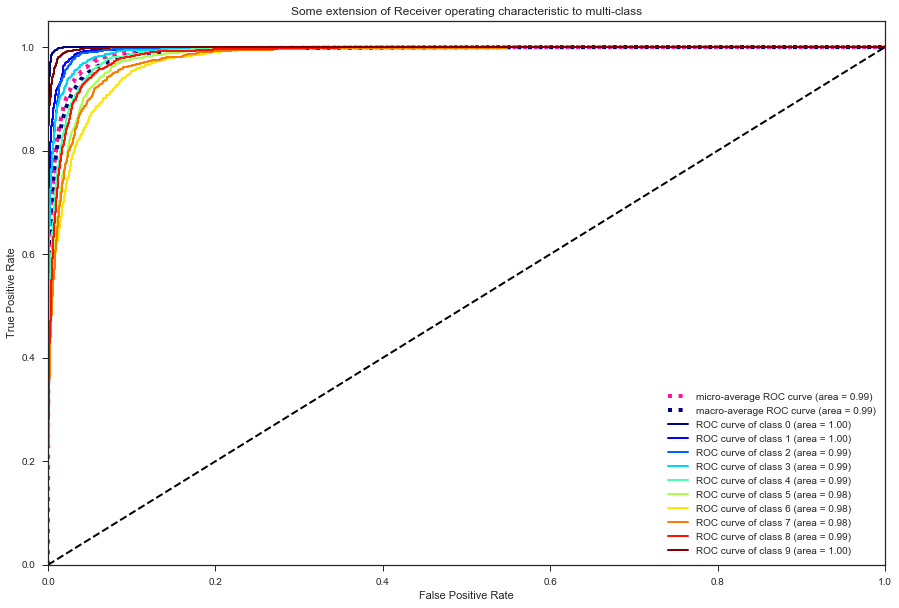

In [395]:
# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_sum[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_sum.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Classifier on multi-classification (10 classes) with Sum feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_GBM_Sum_10Classes.png', dpi=200)
plt.show()

(0, 9)


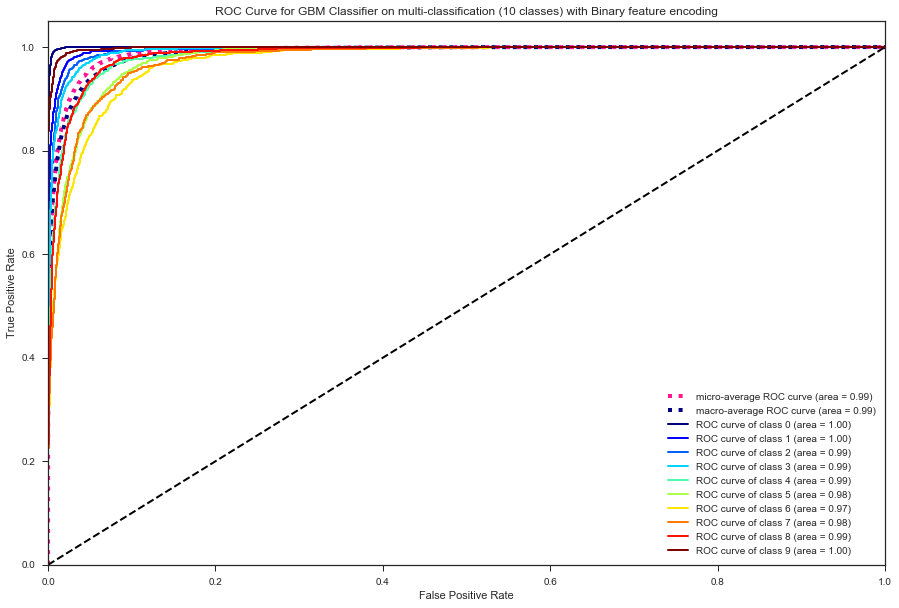

In [406]:
# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_bin.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Classifier on multi-classification (10 classes) with Binary feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_GBM_Binary_10Classes.png', dpi=200)
plt.show()

(0, 9)


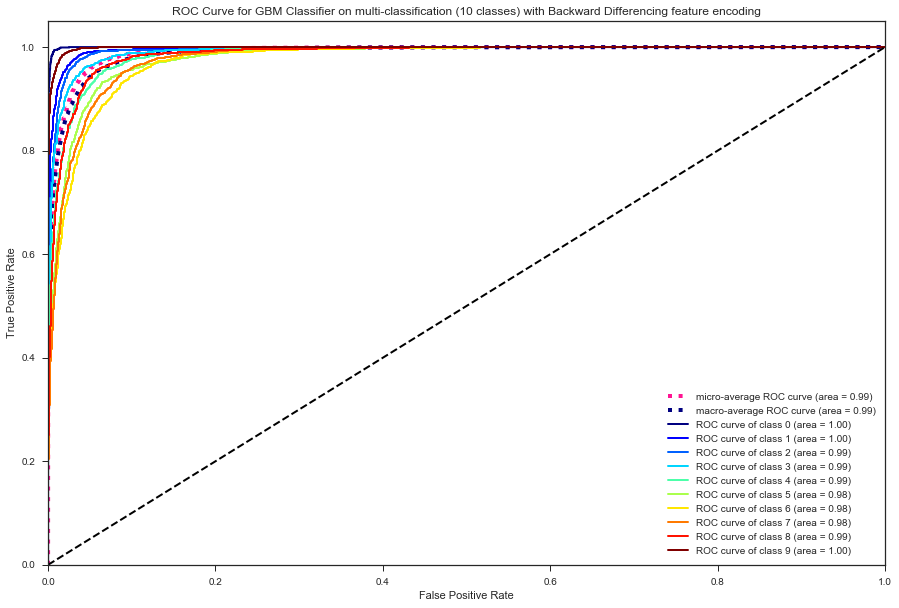

In [407]:
# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_bd[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_bd.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Classifier on multi-classification (10 classes) with Backward Differencing feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_GBM_BD_10Classes.png', dpi=200)
plt.show()

(0, 9)


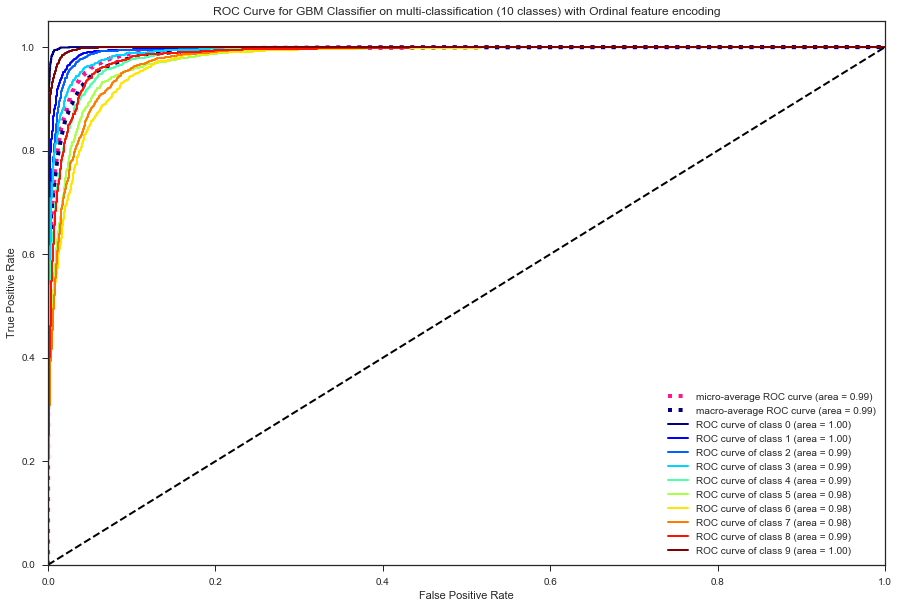

In [408]:
# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_ord[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_ord.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Classifier on multi-classification (10 classes) with Ordinal feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_GBM_Ord_10Classes.png', dpi=200)
plt.show()

(0, 9)


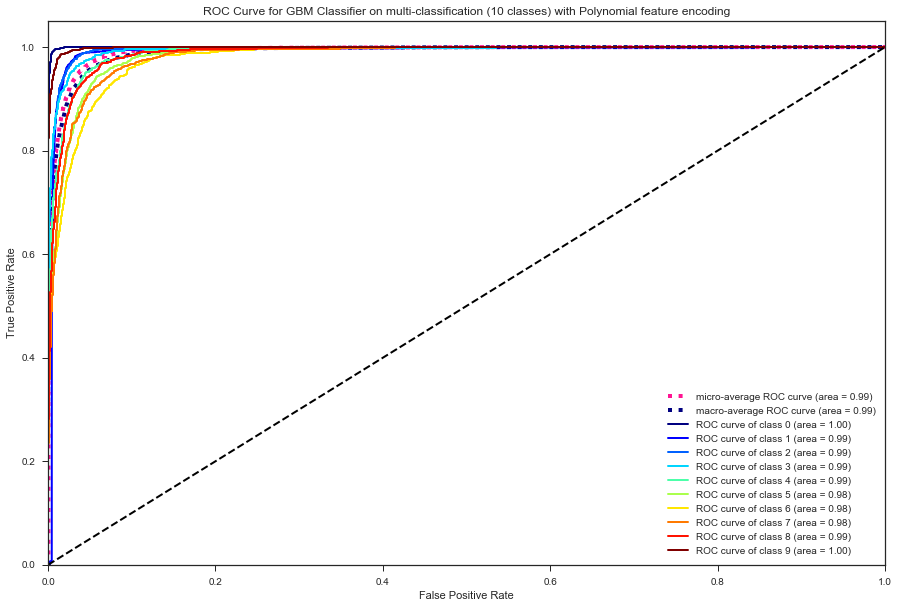

In [409]:
# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_poly[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_poly.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Classifier on multi-classification (10 classes) with Polynomial feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_GBM_Poly_10Classes.png', dpi=200)
plt.show()

(0, 9)


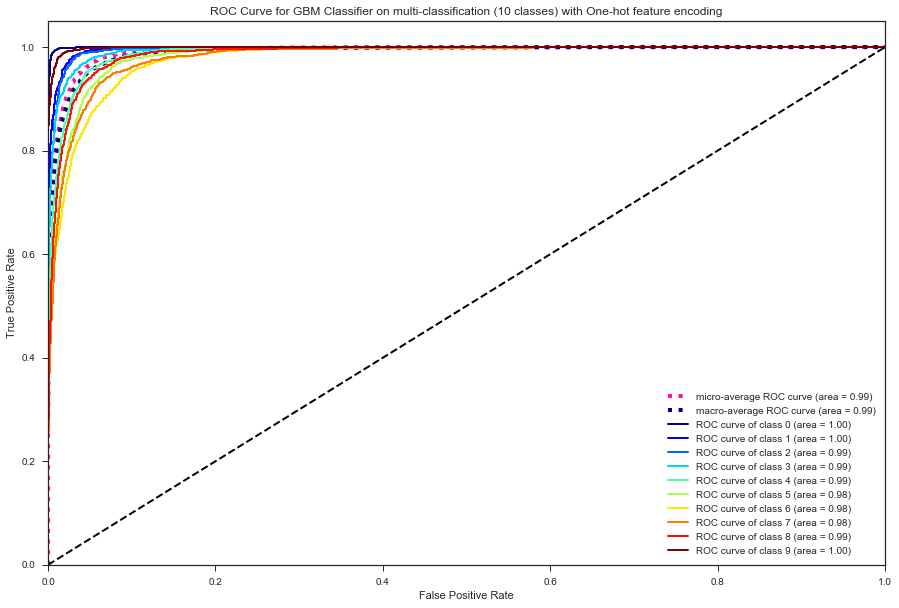

In [410]:
# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_onh[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_onh.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Classifier on multi-classification (10 classes) with One-hot feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_GBM_ONH_10Classes.png', dpi=200)
plt.show()

(0, 9)


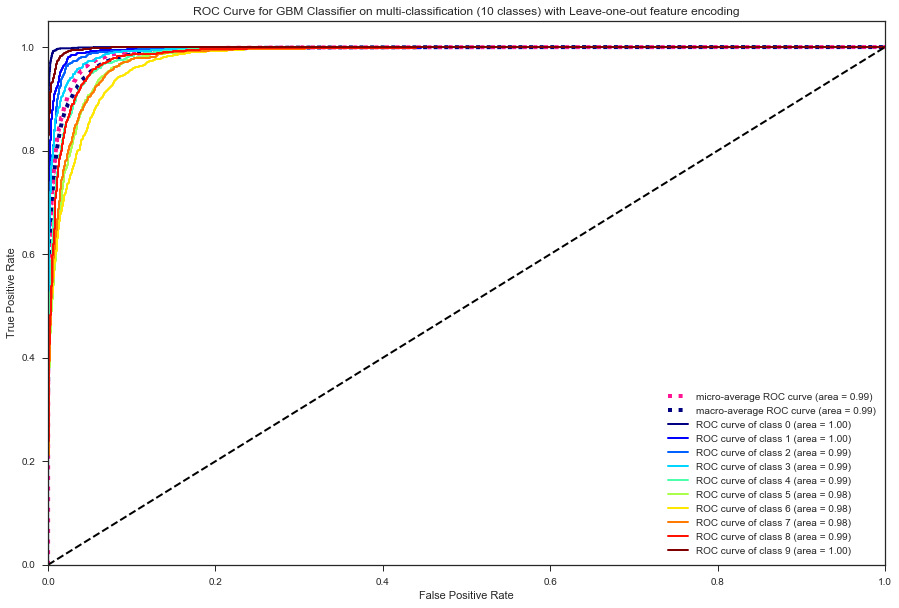

In [411]:
# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_lou[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_lou.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Classifier on multi-classification (10 classes) with Leave-one-out feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_GBM_LOU_10Classes.png', dpi=200)
plt.show()

(0, 9)


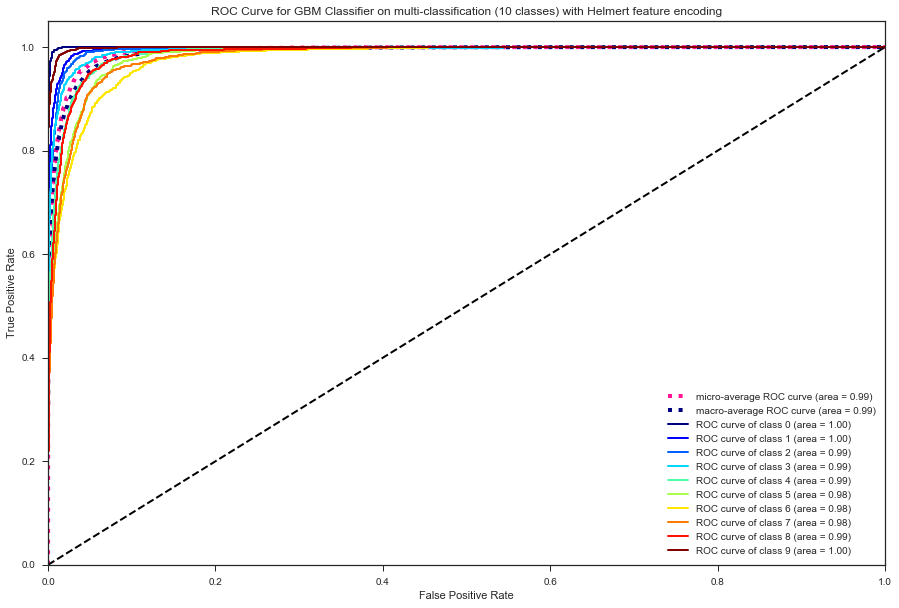

In [412]:
# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_helmert[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_helmert.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Classifier on multi-classification (10 classes) with Helmert feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_GBM_Helmert_10Classes.png', dpi=200)
plt.show()

(0, 9)


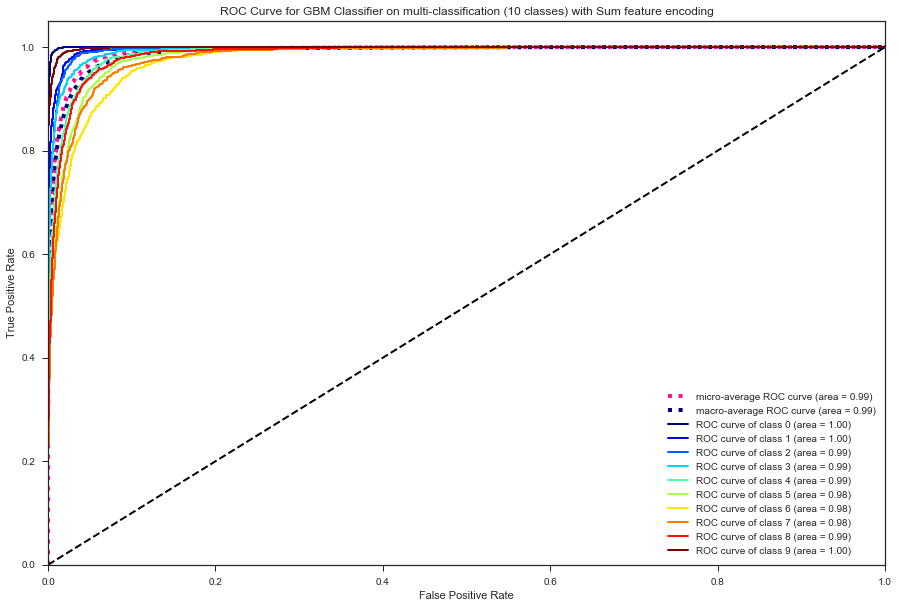

In [413]:
# Compute ROC curve and ROC area for each class
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_sum[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score_sum.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)


lw = 2

jet = cm = plt.get_cmap('jet') 
cNorm  = clrs.Normalize(vmin=0, vmax=9)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
print(scalarMap.get_clim())

colours = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colours):
    colorVal = scalarMap.to_rgba(i)
    plt.plot(fpr[i], tpr[i], color=colorVal, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for GBM Classifier on multi-classification (10 classes) with Sum feature encoding')
plt.legend(loc="lower right")
plt.savefig('ROC_GBM_Sum_10Classes.png', dpi=200)
plt.show()